## HousePrice dataset

PROBLEM STATEMENT

Imagine that a real estate company approached us with an offer to develop a project using machine learning to predict house prices.

THE MAIN OBJECTIVE OF PROJECT

We have to analyze the housing market and evaluate the factors that affect pricing and find model that could predict price on house.  We have received information on real estate sales from 2006 to 2010, as well as a large number of independent variables that we have to study.

### 1. Import libraries & download dataset

In [48]:
#Disable warnings

import os
os.environ['PYTHONWARNINGS'] = 'ignore::UserWarning'
os.environ['PYTHONWARNINGS'] = 'ignore::PerformanceWarning'

import warnings
warnings.filterwarnings('ignore')

#For loading dataset & for linear algebra & statistical analysis
import numpy as np
import pandas as pd
import scipy.stats as stats

#Visualization of data
import matplotlib.pyplot as plt
import seaborn as sns

#Pipeline
from sklearn.pipeline import Pipeline

#Model training preparation
from sklearn.model_selection import train_test_split


from sklearn.model_selection import GridSearchCV

#Discretization
from feature_engine.discretisation import EqualFrequencyDiscretiser

#Missing value imputation
from feature_engine.imputation import (ArbitraryNumberImputer,
                                       EndTailImputer,
                                       CategoricalImputer,
                                       MeanMedianImputer, 
                                       RandomSampleImputer)
#Encoding
from feature_engine.encoding import (CountFrequencyEncoder,
                                     OneHotEncoder, 
                                     OrdinalEncoder,
                                     RareLabelEncoder)

from sklearn.preprocessing import StandardScaler

from sklearn.linear_model import Lasso, BayesianRidge
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR

from sklearn import set_config

from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from math import sqrt

### Functions

In [2]:
# Show in DataFrame missing values with type of variable

def missing_value_info(df):
    nan_list = [var for var in df.columns if df[var].isnull().sum() > 0]
    info_na = df[nan_list].isnull().mean().round(3).sort_values(ascending = False).reset_index()
    info_na.columns = ['Columns','Nan_mean']
    info_na['Type'] = info_na.Columns.map(df.dtypes)
    info_na.Type = np.where(info_na.Type == 'O','Categorical', info_na.Type)
    info_na.Type = np.where(info_na.Type != 'Categorical','Numerical', info_na.Type)

    return info_na

# Visualizing in plot missing values
def missing_value_info_plot(df):    
    info = missing_value_info(df)
    plt.figure(figsize=(len(info.Columns) * 1.5, 2.5))
    plt.plot(info.Nan_mean,'b.-')
    plt.axhline(y = 0.5,color = 'red')
    plt.yticks(np.arange(0, 1.2, 0.2))
    plt.xticks(info.Columns.index,info.Columns,rotation = 90)
    plt.ylabel('Percentage of missing data')
    plt.grid()
    
    plt.show()

In [3]:
# Define categorical & numerical variables

def categorical_numerical_splitter(df):
    cat = []
    num = []
    
    for i in df.columns:
        
        if df[i].dtype == np.object0:
            
            cat.append(i)
            
        else:
            
            num.append(i)
            
    return cat, num

In [4]:
# Check unique labels in categories

def show_unique_labels(df):
    
    len_dict = {}
    sorted_col_list = []
    
    for i in categorical_numerical_splitter(df)[0]:
        
        len_dict[i] = len(df[i].unique())
        
    for i in sorted(len_dict.values(),reverse=True):
        
        for j in categorical_numerical_splitter(df)[0]:
            if len_dict[j] == i:
                sorted_col_list.append(j)
                
    unique_labels = pd.DataFrame()
    
    for col in sorted_col_list:
        
        unique_labels[col] = pd.DataFrame(df[col].value_counts().index)
        unique_labels[col+'_mean'] = pd.Series((df[col].value_counts()/len(df[col])).values)
        
    return unique_labels.fillna('--')

In [5]:
# Function to drop variables from dataset

def drop_useless_col(df, add_drop = []):
    drop_list = [var for var in df.columns if df[var].isnull().mean() > 0.45] + add_drop
    if add_drop == []:
        df = df.drop(columns = drop_list)
    else:
        df = df.drop(columns = drop_list + add_drop)
    
    if drop_list != []:
        print('Dropped : ', drop_list)
        print('='*50)
    else:
        print('Nothing to drop!')
        
    return df

In [6]:
# For analysis categorical variables: searching dominant labels
def dominant_cat_analyser(train, train_target, searching_type, drow):
    dominant_cat_list = []
    test = pd.DataFrame()
    tmp_df = show_unique_labels(train)
    for i in categorical_numerical_splitter(train)[0]:
        test[i] = tmp_df[i + '_mean']
        if searching_type == 'hard':
            if test[i][0] > 0.8:
                if drow == 'yes':
                    categorical_var_analyser(train, train_target, i)
                dominant_cat_list.append(i)
        elif searching_type == 'light':
            if (test[i][:2].sum() > 0.8)and(test[i][0]<0.5):
                if drow == 'yes':
                    categorical_var_analyser(train, train_target, i)
                dominant_cat_list.append(i)
        else:
            print('Wrong parameters')
    return dominant_cat_list

In [7]:
# Visualizing missing values in dataset

def missing_plot_categoric(df):
    categoric_vars = list(df.select_dtypes(include = 'O'))
    plt.figure(figsize = (10, 6))
    plt.title('Percentage of missing values')
    missing_count = pd.DataFrame(df[[col for col in categoric_vars if df[col].isnull().mean() > 0]].isnull().mean() * 100,
                                 columns = ['Percentage (%)']).sort_values(by = ['Percentage (%)'], 
                                                                 ascending = False).reset_index()
    missing_count.columns = ['Features', 'Percentage (%)']
    sns.barplot(x = 'Percentage (%)', y = 'Features', data = missing_count, palette='Blues_r')

In [8]:
# Visualizing missing values in dataset

def missing_plot_numeric(df):
    numeric_vars = list(df.select_dtypes(exclude = 'O'))
    plt.figure(figsize = (8, 3))
    plt.title('Percentage of missing values')
    missing_count = pd.DataFrame(df[[col for col in numeric_vars if df[col].isnull().mean() > 0]].isnull().mean() *100,
                                 columns = ['Percentage (%)']).sort_values(by = ['Percentage (%)'], 
                                                                 ascending = False).reset_index()
    missing_count.columns = ['Features', 'Percentage (%)']
    sns.barplot(x = 'Percentage (%)', y = 'Features', data = missing_count, palette='Blues_r')

In [9]:
# Mean price of house in dataset

def calculate_mean_target_per_category(df, df_target, var):
    total_houses = len(df)
    
    tmp_df = pd.concat([df, df_target], axis = 1)
    
    perc_house_df = pd.Series(tmp_df[var].value_counts()/total_houses).reset_index()
    perc_house_df.columns = [var, 'perc_houses']
    
    perc_house_df = perc_house_df.merge(tmp_df.groupby(var)['SalePrice'].mean().reset_index(), 
                           on = var, 
                           how = 'left')
    return perc_house_df

In [10]:
# Two plots in one figure: labels of categorical variable & mean price by labels

def plot_categories(train,train_target,var):
    
    tmp_df = pd.concat([train,train_target],axis=1)
    
    plot_mean_dict = ((tmp_df.groupby(var)[var].count().sort_values(ascending = False)/len(train))*100).to_dict()
    tmp_var = train[var].value_counts()
    max_mean = plot_mean_dict[tmp_var.reset_index()['index'][0]]
    
    line_plot_dict = tmp_df.groupby(var)[train_target.name].mean().to_dict()
    right_index_plot_dict = {}
    for i in plot_mean_dict:
        right_index_plot_dict[i] = line_plot_dict[i]
    
    my_color_count_dict = {}
    
    for i in list(tmp_var.index):
        if i != np.nan:
            if (plot_mean_dict[i] > 5) and ((plot_mean_dict[i] > max_mean-max_mean*0.2) 
                                            and (plot_mean_dict[i] < max_mean+max_mean*0.2)):
                my_color_count_dict[i] = 'steelblue'
            elif (plot_mean_dict[i] > 5):
                my_color_count_dict[i] = 'lightskyblue'
            else:
                my_color_count_dict[i] = 'lavender'
                
    ax = plt.subplots()
    plt.title(var)
    ax = pd.Series(plot_mean_dict).plot.bar(color = my_color_count_dict.values())
    plt.ylabel('Percentage (%)')
    ax2 = ax.twinx()
    ax2 = pd.Series(right_index_plot_dict).plot(color = 'b',marker = 'o')
    plt.ylabel('Mean price')
    ax.axhline(y = 5, color = "red",alpha = 0.6)
    ax.grid(axis='y')
    plt.show()

In [11]:
# Visualizing histogram, probability plot and box-plot

def diagnostic_plots(df, variable):
    fig = plt.figure()
    plt.figure(figsize = (18, 5))
    
    # Histogram
    plt.subplot(1, 3, 1)
    fig = df[variable].hist(bins = 30)
    fig.set_ylabel ('Number of houses')
    fig.set_xlabel(variable)
    
    # Probability plot
    plt.subplot(1, 3, 2)
    stats.probplot(df[variable], dist = 'norm', plot = plt)
    
    # Box-plot
    plt.subplot(1, 3, 3)
    fig = df.boxplot(column = variable)
    fig.set_title('')
    fig.set_ylabel(variable)

    plt.show()

In [12]:
# Visualizing density plot after imputation

def kde_plot_with_missing_imputation(df, target, variable):
    
    tmp_df = pd.concat([df, target],axis=1)
    
    if tmp_df[variable].isnull().sum() > 0:
        tmp_df = tmp_df.dropna()
    
    fig = plt.figure(figsize = (8, 5))
    ax = fig.add_subplot(111)
    
    for category in tmp_df[variable].unique():
        if category == 'Missing':
                
            tmp_df[tmp_df[variable] == category][target.name].plot(kind = 'kde', 
                                                                   ax = ax, 
                                                                   color = 'r')
        else:
        
            tmp_df[tmp_df[variable] == category][target.name].plot(kind = 'kde', 
                                                               ax = ax)      
        
    lines, labels = ax.get_legend_handles_labels()
    labels = tmp_df[variable].unique()
    
    ax.legend(lines, labels, loc = 'best')
    plt.show()

In [13]:
# Check correlation and drop variables with weak correlation (lower than tolerance)

def main_correlation_filter(df, df_target, tolerance):
    corr_matrix = pd.concat([df, df_target], axis = 1).corr()
    total_list = []
    total_df = pd.DataFrame()
    for i in list(corr_matrix.columns):
        adding_df = corr_matrix[(abs(corr_matrix[i]) < tolerance) &
                                (corr_matrix[i]!= 1.0)]['SalePrice']
        if adding_df.empty:
            pass
        else:
            total_list.append(adding_df)
    temporary_df = pd.DataFrame(total_list).round(2)

    drop_list = list(temporary_df.iloc[-1].dropna().index)
    
    return drop_list

In [14]:
# Plot after discretization 

def disc_plot(df, target_df, variable):
    pd.concat([df, target_df], axis = 1).groupby([var])[target_df.name].mean().plot()
    plt.ylabel('mean')
    plt.xlabel(variable)
    plt.show()

In [15]:
# Checking multicollinearity

def multicollinearity(df, threshold):
    
    col_corr = set()
    
    corr_matrix = df.corr().round(3)
    
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if abs(corr_matrix.iloc[i, j]) > threshold:
                print(abs(corr_matrix.iloc[i, j]), corr_matrix.columns[i], corr_matrix.columns[j])

## 2.Exploratory data analysis (EDA)

### Data overview

In [16]:
# Load dataset
data = pd.read_csv('houseprice.csv')

## Feature enginnering

### Creating a new feature 'HouseAge'

In [17]:
data['HouseAge'] = data['YrSold'] - data['YearBuilt']
data['HouseAge'].unique()

array([  5,  31,   7,  91,   8,  16,   3,  36,  77,  69,  43,   1,  46,
        48,  78,  40,  39,   4,  51,   6,  42,   2,  59,  49,  81,  88,
        15,  55,  57,  53,  41,  24,  33,  47,  89,  10,  72,  25,  52,
        44,   0,  87,  12,  65,  34,  11,  56,  95,  60,  99,  14,  94,
        13,  45,  97,  90,  30,  76, 122,  54,  62,  20,  37,  68,  50,
        71,   9,  38,  18,  58,  70,  32,  35,  83,  84,  66,  19,  22,
        86,  98, 114,  93,  75,  82,  17, 106,  29,  96,  27,  92, 128,
        61,  67,  21,  26, 108,  28,  63,  73,  74,  80, 115, 126, 102,
        85,  23, 110, 117, 129,  64, 100, 111, 104, 119, 127, 107, 135,
       109, 136, 103,  79, 125])

### Creating a new feature 'RemodHouse'

In [18]:
data['RemodHouse'] = data['YrSold'] - data['YearRemodAdd']
data['RemodHouse'].unique()

array([ 5, 31,  6, 36,  8, 14,  2, 58, 43,  0, 46, 48, 40, 39,  4, 44, 57,
        9, 10,  1, 51, 19,  3, 53, 41, 24, 28, 47, 56, 52, 11, 60, 21, 34,
        7, 42, 13, 27, 12, 45, 16, 25, 30, 33, 54, 20, 37, 50, 15, 38, 17,
       32, 35, 22, 18, 59, 29, 49, 26, -1, 55, 23])

### Creating a new feature 'GarageAge'

In [19]:
data['GarageAge'] = data['YrSold'] - data['GarageYrBlt']
data['GarageAge'].unique()

array([  5.,  31.,   7.,   8.,  16.,   3.,  36.,  77.,  69.,  43.,   1.,
        46.,  48.,  40.,  39.,   4.,  51.,   6.,  42.,   2.,  49.,  88.,
        14.,  55.,  57.,  nan,  41.,  24.,  47.,  10.,  21.,  25.,  45.,
        44.,   0.,  35.,  72.,  20.,  11.,  65.,  53.,  34.,  95.,  52.,
        60.,  33.,  15.,  56., 107.,  90.,  30.,  54.,  62.,  37.,  28.,
        50.,   9.,  38.,  17.,  12.,  78.,  70.,  32.,  83.,  81.,  19.,
        22.,  86.,  13.,  93.,  75.,  82.,  61.,  66.,  18.,  29.,  96.,
        27.,  59.,  67.,  26.,  79.,  89.,  68.,  87.,  74.,  92.,  94.,
        71.,  80.,  58.,  84.,  23.,  76.,  73., 102.,  85.,  97.,  64.,
        99., 100.,  91.])

### Creating a new feature 'Season'

In [20]:
data['Season'] = data['MoSold'].copy()

In [21]:
data = data.replace({'Season': {1: 'winter', 2: 'winter', 12: 'winter', 
                                    3: 'spring', 4: 'spring', 5: 'spring', 
                                    6: 'summer', 7: 'summer', 8: 'summer', 
                                    9: 'autumn', 10:'autumn', 11: 'autumn'}})
data[['MoSold', 'Season']].head(10)

,MoSold,Season
0,2,winter
1,5,spring
2,9,autumn
3,2,winter
4,12,winter
5,10,autumn
6,8,summer
7,11,autumn
8,4,spring
9,1,winter


In [22]:
#Drop features:
data = data.drop(['YearBuilt', 'YearRemodAdd', 'MoSold', 'YrSold', 'GarageYrBlt'], axis = 1)

## 2.1. Splitting dataset on train and test data

## 3. Data preprocessing & Feature engineering

### Dropping redundant columns

In [23]:
X_train,X_test,y_train,y_test = train_test_split(data.drop(columns=['SalePrice', 'Id'], axis=1),
                                                 data.SalePrice,
                                                 test_size=0.3,
                                                 random_state=0)

print("Training data set dimension : {}".format(X_train.shape))
print("Testing data set dimension : {}".format(X_test.shape))

Training data set dimension : (1022, 78)
Testing data set dimension : (438, 78)


In [24]:
#list of variables with low correlation with 'SalePrice'
weak_corr_list = main_correlation_filter(X_train, y_train, 0.21)
weak_corr_list

['OverallCond',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'LowQualFinSF',
 'BsmtHalfBath',
 'BedroomAbvGr',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'KitchenAbvGr',
 'MSSubClass']

In [25]:
#Drop: '1stFlrSF' , '2ndFlrSF', 'TotRmsAbvGrd', 'GarageArea', 'GarageAge'
multicollinearity_features_drop = ['1stFlrSF', 
                                   '2ndFlrSF', 
                                   'TotRmsAbvGrd', 
                                   'GarageArea', 
                                   'GarageAge']

In [26]:
total_list_to_drop = weak_corr_list + multicollinearity_features_drop + dominant_cat_analyser(X_train, y_train, 'hard', 'no')

In [27]:
X_train = drop_useless_col(X_train, total_list_to_drop)
X_test = drop_useless_col(X_test, total_list_to_drop)

Dropped :  ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtHalfBath', 'BedroomAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'KitchenAbvGr', 'MSSubClass', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'GarageArea', 'GarageAge', 'MSZoning', 'Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
Dropped :  ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtHalfBath', 'BedroomAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'KitchenAbvGr', 'MSSubClass', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'GarageArea', 'GarageAge', 'MSZoning', 'Street', 'LandContour', 'Utilities', 'LandSlope', 'Condit

In [28]:
X_train.shape, X_test.shape

((1022, 34), (438, 34))

## Part 3. Machine Learning Models with Pipeline & Interpreting results
### 1. Hyper-parameters tuning and  Modeling with GridSearch & Pipeline

In [29]:
X_train,X_test,y_train,y_test = train_test_split(data.drop(columns=['SalePrice', 'Id'], axis=1),
                                                 data.SalePrice,
                                                 test_size=0.3,
                                                 random_state=0)

print("Training data set dimension : {}".format(X_train.shape))
print("Testing data set dimension : {}".format(X_test.shape))

Training data set dimension : (1022, 78)
Testing data set dimension : (438, 78)


In [30]:
#list of features with high multicollinearity
multicollinearity_features_drop = ['1stFlrSF', 
                                   '2ndFlrSF', 
                                   'TotRmsAbvGrd', 
                                   'GarageArea', 
                                   'GarageAge']

In [31]:
#list of features with weak correlation (less than 20% to target feature 'SalePrice')
weak_corr_list = main_correlation_filter(X_train, y_train, 0.21)
weak_corr_list

['OverallCond',
 'BsmtFinSF2',
 'BsmtUnfSF',
 'LowQualFinSF',
 'BsmtHalfBath',
 'BedroomAbvGr',
 'EnclosedPorch',
 '3SsnPorch',
 'ScreenPorch',
 'PoolArea',
 'MiscVal',
 'KitchenAbvGr',
 'MSSubClass']

In [32]:
total_list_to_drop = weak_corr_list + multicollinearity_features_drop + dominant_cat_analyser(X_train, y_train, 'hard', 'no')

In [33]:
X_train = drop_useless_col(X_train, total_list_to_drop)
X_test = drop_useless_col(X_test, total_list_to_drop)

Dropped :  ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtHalfBath', 'BedroomAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'KitchenAbvGr', 'MSSubClass', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'GarageArea', 'GarageAge', 'MSZoning', 'Street', 'LandContour', 'Utilities', 'LandSlope', 'Condition1', 'Condition2', 'BldgType', 'RoofMatl', 'ExterCond', 'BsmtCond', 'BsmtFinType2', 'Heating', 'CentralAir', 'Electrical', 'Functional', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition']
Dropped :  ['Alley', 'FireplaceQu', 'PoolQC', 'Fence', 'MiscFeature', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF', 'LowQualFinSF', 'BsmtHalfBath', 'BedroomAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'KitchenAbvGr', 'MSSubClass', '1stFlrSF', '2ndFlrSF', 'TotRmsAbvGrd', 'GarageArea', 'GarageAge', 'MSZoning', 'Street', 'LandContour', 'Utilities', 'LandSlope', 'Condit

In [34]:
X_train.shape, X_test.shape

((1022, 34), (438, 34))

In [35]:
numeric_vars = [var for var in X_train.columns if X_train[var].dtypes != 'O'
               and var != 'SalePrice']

In [36]:
discrete = [var for var in X_train.columns if X_train[var].dtype != 'O' 
            and var != 'SalePrice' and X_train[var].nunique()<20]

In [37]:
num_list = [var for var in numeric_vars if var not in discrete 
                and var not in ['Id', 'SalePrice']]

In [38]:
categorical_vars = [var for var in X_train.columns if X_train[var].dtype == 'O']

In [39]:
cat_list = categorical_vars + discrete

In [40]:
X_train[cat_list] = X_train[cat_list].astype('O')
X_test[cat_list] = X_test[cat_list].astype('O')

In [41]:
X_train.shape, X_test.shape

((1022, 34), (438, 34))

## Pipelines with Grid-Search CV

### Hyperparameters for Random Forest Regressor

In [54]:
pipe_rfr = Pipeline(steps = [('imputer_num', MeanMedianImputer(imputation_method = 'mean', variables = num_list)), 
                         ('imputer_cat', CategoricalImputer(imputation_method = 'frequent', variables = cat_list)), 
                         ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)), 
                         ('discretizer', EqualFrequencyDiscretiser(q = 6, return_object = True, variables = num_list)), 
                         ('encoder', OneHotEncoder()), 
                         ('scaler', StandardScaler()), 
                         ('RF', RandomForestRegressor(n_estimators = 200, 
                                                      random_state = 0, 
                                                      #criterion = 'absolute_error', 
                                                     min_samples_split = 0.01, 
                                                     min_samples_leaf = 0.01))])

In [55]:
rfr_param_grid = [{
    'imputer_num__imputation_method':['mean','median'],
    'imputer_cat__imputation_method':['frequent','missing'],
    'encoder': [OrdinalEncoder(encoding_method = 'ordered'),
                CountFrequencyEncoder(encoding_method = 'count'), 
                OneHotEncoder()], 
    'discretizer__q':[5, 6, 7], 
    'RF__n_estimators': [100, 200, 300], 
    'RF__max_depth': [2, 3, 4], 
    #'RF__criterion' : ['squared_error', 'absolute_error'], 
    'RF__min_samples_leaf': [0.01, 1, 2], 
    'RF__min_samples_split': [0.01, 0.5, 1]
}]

In [56]:
rfr_grid_search = GridSearchCV(estimator = pipe_rfr, param_grid = rfr_param_grid, cv = 5, 
                               n_jobs = -1, scoring = 'r2')

In [ ]:
rfr_grid_search.fit(X_train, y_train)

In [ ]:
print('{} R2 score train set: {}'.format('RandomForest', rfr_grid_search.score(X_train, y_train)))
print('{} R2 score train set: {}'.format('RandomForest', rfr_grid_search.score(X_test, y_test)))

In [ ]:
rfr_grid_search.best_params_

### Hyperparameters for Decision Tree Regressor

In [ ]:
pipe_dtr = Pipeline(steps = [('imputer_num', MeanMedianImputer(imputation_method = 'mean', variables = num_list)), 
                         ('imputer_cat', CategoricalImputer(imputation_method = 'frequent', variables = cat_list)), 
                         ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)), 
                         ('discretizer', EqualFrequencyDiscretiser(q = 6, return_object = False, variables = num_list)), 
                         ('encoder', OneHotEncoder()), 
                         ('scaler', StandardScaler()), 
                         ('DTR', DecisionTreeRegressor(random_state = 0, 
                                                      min_samples_split = 0.01,  
                                                      min_samples_leaf = 0.01, 
                                                      criterion = 'squared_error'))])

In [ ]:
dtr_param_grid = [{
    'imputer_num__imputation_method':['mean','median'], 
    'imputer_cat__imputation_method':['frequent','missing'],
    'encoder': [OrdinalEncoder(encoding_method = 'ordered'),
                CountFrequencyEncoder(encoding_method = 'count'), 
                OneHotEncoder()], 
    'discretizer__q':[5, 6, 7], 
    'DTR__max_depth': [2, 3, 4], 
    'DTR__criterion' : ['squared_error', 'absolute_error'], 
    'DTR__min_samples_leaf': [1.0, 0.05, 0.01], 
    'DTR__min_samples_split': [0.01, 0.5, 1], 
    'DTR__max_features': ['auto']
}]

In [ ]:
dtr_grid_search = GridSearchCV(estimator = pipe_dtr, param_grid = dtr_param_grid, cv = 5, 
                               n_jobs = -1, scoring = 'r2')

In [ ]:
dtr_grid_search.fit(X_train, y_train)

In [ ]:
print('{} R2 score train set: {}'.format('Decision Tree Regressor', dtr_grid_search.score(X_train, y_train)))
print('{} R2 score train set: {}'.format('Decision Tree Regressor', dtr_grid_search.score(X_test, y_test)))

In [ ]:
dtr_grid_search.best_params_

### Hyperparameters for XGBoost Regressor

In [543]:
pipe_xgb = Pipeline(steps = [('imputer_num', MeanMedianImputer(imputation_method = 'mean', variables = num_list)), 
                         ('imputer_cat', CategoricalImputer(imputation_method = 'missing', variables = cat_list)), 
                         ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)), 
                         ('discretizer', EqualFrequencyDiscretiser(q = 6, return_object = False, variables = num_list)), 
                         ('encoder', OneHotEncoder()), 
                         ('scaler', StandardScaler()), 
                         ('XGB', XGBRegressor(random_state = 0, gamma = 1, 
                                              learning_rate = 0.01, 
                                              min_child_weight = 0.01, 
                                              max_depth = 2))])

In [544]:
xgb_param_grid = [{
    'imputer_num__imputation_method':['mean','median'], 
    'imputer_cat__imputation_method':['frequent','missing'],
    'encoder': [OrdinalEncoder(encoding_method = 'ordered'),
                CountFrequencyEncoder(encoding_method = 'count'), 
                OneHotEncoder()], 
    'discretizer__q':[5, 6, 7], 
    'XGB__n_estimators' : [200, 300, 400], 
    'XGB__max_depth': [2, 3],
    'XGB__learning_rate': [0.01, 0.05, 0.1], 
    'XGB__gamma': [0, 1, 10],
    'XGB__min_child_weight': [0.01, 0.1, 0.5]
}]

In [545]:
xgb_grid_search = GridSearchCV(estimator = pipe_xgb, param_grid = xgb_param_grid, cv = 5, 
                               n_jobs = -1, scoring = 'r2')

In [ ]:
xgb_grid_search.fit(X_train, y_train)

In [547]:
print('{} R2 score train set: {}'.format('XGBoost Regressor', xgb_grid_search.score(X_train, y_train)))
print('{} R2 score train set: {}'.format('XGBoost Regressor', xgb_grid_search.score(X_test, y_test)))

XGBoost Regressor R2 score train set: 0.8664324277097468
XGBoost Regressor R2 score train set: 0.8336057818615815


In [ ]:
xgb_grid_search.best_params_

### Hyperparameters for Lasso

In [ ]:
pipe_lasso = Pipeline(steps = [('imputer_num', MeanMedianImputer(imputation_method = 'mean', variables = num_list)), 
                         ('imputer_cat', CategoricalImputer(imputation_method = 'frequent', variables = cat_list)), 
                         ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)), 
                         ('discretizer', EqualFrequencyDiscretiser(q = 6, return_object = True, variables = num_list)), 
                         ('encoder', OneHotEncoder(variables = cat_list)), 
                         ('scaler', StandardScaler()), 
                         ('Lasso', Lasso(random_state = 0, alpha = 0.01))])

In [ ]:
lasso_param_grid = [{
    'imputer_num__imputation_method':['mean','median'], 
    'imputer_cat__imputation_method':['frequent','missing'],
    'encoder': [OrdinalEncoder(encoding_method = 'ordered'),
                CountFrequencyEncoder(encoding_method = 'count'), 
                OneHotEncoder()], 
    'discretizer__q':[6, 10, 12], 
    'Lasso__alpha': [0.01, 0.5, 1], 
    'Lasso__max_iter': [500, 800, 1000]
}]

In [ ]:
lasso_grid_search = GridSearchCV(estimator = pipe_lasso, param_grid = lasso_param_grid, cv = 5, 
                                 n_jobs = -1, scoring = 'r2')

In [ ]:
lasso_grid_search.fit(X_train, y_train)

In [ ]:
print('{} R2 score train set: {}'.format('Lasso', lasso_grid_search.score(X_train, y_train)))
print('{} R2 score train set: {}'.format('Lasso', lasso_grid_search.score(X_test, y_test)))

In [ ]:
lasso_grid_search.best_params_

### Hyperparameters for KNeighborsRegressor

In [ ]:
pipe_knn = Pipeline(steps = [('imputer_num', MeanMedianImputer(imputation_method = 'mean', variables = num_list)), 
                         ('imputer_cat', CategoricalImputer(imputation_method = 'frequent', variables = cat_list)), 
                         ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)), 
                         ('discretizer', EqualFrequencyDiscretiser(q = 6, return_object = True, variables = num_list)), 
                         ('encoder', OneHotEncoder()), 
                         ('scaler', StandardScaler()), 
                         ('KNN', KNeighborsRegressor(p = 2, metric = 'minkowski', algorithm = 'auto', leaf_size = 2, 
                                                           weights = 'uniform', n_neighbors = 3))])

In [ ]:
knn_param_grid = [{
    'imputer_num__imputation_method':['mean','median'], 
    'imputer_cat__imputation_method':['frequent','missing'],
    'encoder': [OrdinalEncoder(encoding_method = 'ordered'),
                CountFrequencyEncoder(encoding_method = 'count'), 
                OneHotEncoder()], 
    'discretizer__q':[5, 6, 7], 
    'KNN__n_neighbors': [2, 3],
    'KNN__metric': ['minkowski', 'manhattan', 'euclidean'],
    'KNN__leaf_size': [1, 2]
}]

In [ ]:
knn_grid_search = GridSearchCV(estimator = pipe_knn, param_grid = knn_param_grid, cv = 5, 
                                 n_jobs = -1, scoring = 'r2')

In [ ]:
knn_grid_search.fit(X_train, y_train)

In [ ]:
print('{} R2 score train set: {}'.format('KNN', knn_grid_search.score(X_train, y_train)))
print('{} R2 score train set: {}'.format('KNN', knn_grid_search.score(X_test, y_test)))    

In [ ]:
knn_grid_search.best_params_

### Hyperparameters fot SVR

In [ ]:
pipe_svr = Pipeline(steps = [('imputer_num', MeanMedianImputer(imputation_method = 'mean', variables = num_list)), 
                         ('imputer_cat', CategoricalImputer(imputation_method = 'frequent', variables = cat_list)), 
                         ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)), 
                         ('discretizer', EqualFrequencyDiscretiser(q = 6, return_object = True, variables = num_list)), 
                         ('encoder', OneHotEncoder()), 
                         ('scaler', StandardScaler()), 
                         ('SVR', SVR(kernel = 'linear', gamma = 0.1))])

In [ ]:
svr_param_grid = [{
    'imputer_num__imputation_method':['mean','median'], 
    'imputer_cat__imputation_method':['frequent','missing'],
    'encoder': [OrdinalEncoder(encoding_method = 'ordered'),
                CountFrequencyEncoder(encoding_method = 'count'), 
                OneHotEncoder()], 
    'discretizer__q':[5, 6, 7], 
    'SVR__kernel': ['linear', 'rbf'], 
    'SVR__gamma': [0.01, 0.05, 0.1], 
    'SVR__C': [1.0, 3.0, 5.0]
}]

In [ ]:
svr_grid_search = GridSearchCV(estimator = pipe_svr, param_grid = svr_param_grid, cv = 5, 
                                 n_jobs = -1, scoring = 'r2')

In [ ]:
svr_grid_search.fit(X_train, y_train)

In [ ]:
print('{} R2 score train set: {}'.format('SVR', svr_grid_search.score(X_train, y_train)))
print('{} R2 score train set: {}'.format('SVR', svr_grid_search.score(X_test, y_test)))    

In [ ]:
svr_grid_search.best_params_

### Hyperparameters for GradientBoostingRegressor

In [ ]:
pipe_gbr = Pipeline(steps = [('imputer_num', MeanMedianImputer(imputation_method = 'mean', variables = num_list)), 
                         ('imputer_cat', CategoricalImputer(imputation_method = 'frequent', variables = cat_list)), 
                         ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)), 
                         ('discretizer', EqualFrequencyDiscretiser(q = 6, return_object = True, variables = num_list)), 
                         ('encoder', OneHotEncoder(variables = cat_list)), 
                         ('scaler', StandardScaler()), 
                         ('gbr', GradientBoostingRegressor(n_estimators=200, loss = 'squared_error' ,
                                                          learning_rate=0.1))])

In [ ]:
gbr_param_grid = [{
    'imputer_num__imputation_method':['mean','median'], 
    'imputer_cat__imputation_method':['frequent','missing'],
    'encoder': [OrdinalEncoder(encoding_method = 'ordered'),
                CountFrequencyEncoder(encoding_method = 'count'), 
                OneHotEncoder()], 
    'discretizer__q':[5, 6, 7], 
    'gbr__n_estimators': [150, 200, 250],
    'gbr__loss': ['squared_error', 'absolute_error', 'huber'], 
    'gbr__max_depth': [1, 2],
    'gbr__min_samples_leaf': [0.1, 0.01],
    'gbr__learning_rate': [1, 0.5, 0.1, 0.01], 
    'gbr__max_features': ['sqrt', 'log2']
}]

In [ ]:
gbr_grid_search = GridSearchCV(estimator = pipe_gbr, param_grid = gbr_param_grid, cv = 5, 
                                 n_jobs = -1, scoring = 'r2')

In [ ]:
gbr_grid_search.fit(X_train, y_train)

In [ ]:
print('{} R2 score train set: {}'.format('GradientBoostingRegressor', gbr_grid_search.score(X_train, y_train)))
print('{} R2 score train set: {}'.format('GradientBoostingRegressor', gbr_grid_search.score(X_test, y_test)))    

In [ ]:
gbr_grid_search.best_params_

### Hyperparameters for BayesianRidge

In [ ]:
pipe_bayesian = Pipeline(steps = [('imputer_num', MeanMedianImputer(imputation_method = 'mean', variables = num_list)), 
                         ('imputer_cat', CategoricalImputer(imputation_method = 'frequent', variables = cat_list)), 
                         ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)), 
                         ('discretizer', EqualFrequencyDiscretiser(q = 6, return_object = True, variables = num_list)), 
                         ('encoder', OneHotEncoder(variables = cat_list)), 
                         ('scaler', StandardScaler()), 
                         ('bayesian', BayesianRidge(n_iter=300))])

In [ ]:
bayesian_param_grid = [{
    'imputer_num__imputation_method':['mean','median'], 
    'imputer_cat__imputation_method':['frequent','missing'],
    'encoder': [OrdinalEncoder(encoding_method = 'ordered'),
                CountFrequencyEncoder(encoding_method = 'count'), 
                OneHotEncoder()], 
    'discretizer__q':[5, 6],
    'bayesian__n_iter': [100, 200, 300]
}]

In [ ]:
bayesian_grid_search = GridSearchCV(estimator = pipe_bayesian, param_grid = bayesian_param_grid, cv = 5, 
                                 n_jobs = -1, scoring = 'r2')

In [ ]:
bayesian_grid_search.fit(X_train, y_train)

In [ ]:
print('{} R2 score train set: {}'.format('BayesianRidge', bayesian_grid_search.score(X_train, y_train)))
print('{} R2 score train set: {}'.format('BayesianRidge', bayesian_grid_search.score(X_test, y_test)))    

In [ ]:
bayesian_grid_search.best_params_

## [Random Forest Regressor] Pipeline with best parameters

In [75]:
pipe_rfr = Pipeline(steps = [('imputer_num', MeanMedianImputer(imputation_method = 'mean', variables = num_list)), 
                         ('imputer_cat', CategoricalImputer(imputation_method = 'missing', variables = cat_list)), 
                         ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)), 
                         ('discretizer', EqualFrequencyDiscretiser(q = 5, return_object = True, variables = num_list)), 
                         ('encoder', OneHotEncoder()), 
                         ('scaler', StandardScaler()), 
                         ('RF', RandomForestRegressor(n_estimators = 250, 
                                                      random_state = 0, 
                                                      criterion = 'absolute_error', 
                                                     min_samples_split = 0.01, 
                                                     min_samples_leaf = 0.01, 
                                                     max_depth = 4))])

In [76]:
pipe_rfr.fit(X_train, y_train)

Pipeline(steps=[('imputer_num',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'LotArea',
                                              'MasVnrArea', 'BsmtFinSF1',
                                              'TotalBsmtSF', 'GrLivArea',
                                              'WoodDeckSF', 'OpenPorchSF',
                                              'HouseAge', 'RemodHouse'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['LotShape', 'LotConfig',
                                               'Neighborhood', 'HouseStyle',
                                               'RoofStyle', 'Exterior1st',
                                               'Exterior2nd'...
                 EqualFrequencyDiscretiser(q=5, return_object=True,
                                           variables=['LotFrontage', 'LotArea',
                                                      'MasVnrArea',
                                                      'BsmtFinSF1',
                                                      'TotalBsmtSF',
                                                      'GrLivArea', 'WoodDeckSF',
                                                      'OpenPorchSF', 'HouseAge',
                                                      'RemodHouse'])),
                ('encoder', OneHotEncoder()), ('scaler', StandardScaler()),
                ('RF',
                 RandomForestRegressor(criterion='absolute_error', max_depth=4,
                                       min_samples_leaf=0.01,
                                       min_samples_split=0.01, n_estimators=250,
                                       random_state=0))])

In [77]:
X_train_preds = pipe_rfr.predict(X_train)
X_test_preds = pipe_rfr.predict(X_test)

In [78]:
print('train MAE: {}'.format(mean_absolute_error(y_train, X_train_preds)))
print('train RMSE: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train R2: {}'.format(r2_score(y_train, X_train_preds)))
print()

print('test MAE: {}'.format(mean_absolute_error(y_test, X_test_preds)))
print('test RMSE: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test R2: {}'.format(r2_score(y_test, X_test_preds)))

train MAE: 22009.78977103718
train RMSE: 34364.90730804139
train R2: 0.8063944174502399

test MAE: 22485.23284931507
test RMSE: 38138.54629206335
test R2: 0.785748925165014


### [Random Forest Regressor] Feature importances

In [79]:
onehot_columns = list(pipe_rfr.named_steps['scaler'].feature_names_in_)

In [80]:
onehot_columns

['OverallQual',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'Fireplaces',
 'GarageCars',
 'LotFrontage_2',
 'LotFrontage_0',
 'LotFrontage_1',
 'LotFrontage_3',
 'LotFrontage_4',
 'LotArea_2',
 'LotArea_0',
 'LotArea_1',
 'LotArea_3',
 'LotArea_4',
 'LotShape_Reg',
 'LotShape_IR1',
 'LotShape_Rare',
 'LotConfig_Inside',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_Rare',
 'Neighborhood_CollgCr',
 'Neighborhood_Rare',
 'Neighborhood_Edwards',
 'Neighborhood_Sawyer',
 'Neighborhood_NAmes',
 'Neighborhood_Gilbert',
 'Neighborhood_Somerst',
 'Neighborhood_OldTown',
 'HouseStyle_2Story',
 'HouseStyle_1Story',
 'HouseStyle_1.5Fin',
 'HouseStyle_Rare',
 'RoofStyle_Gable',
 'RoofStyle_Hip',
 'RoofStyle_Rare',
 'Exterior1st_VinylSd',
 'Exterior1st_Wd Sdng',
 'Exterior1st_Rare',
 'Exterior1st_HdBoard',
 'Exterior1st_MetalSd',
 'Exterior1st_Plywood',
 'Exterior2nd_VinylSd',
 'Exterior2nd_Wd Sdng',
 'Exterior2nd_Plywood',
 'Exterior2nd_Rare',
 'Exterior2nd_HdBoard',
 'Exterior2nd_MetalSd

In [81]:
importance = pd.Series(pipe_rfr.named_steps['RF'].feature_importances_)

In [82]:
importance.index = onehot_columns

In [83]:
importance_new = importance.rename(index = {
 'LotFrontage_2': 'LotFrontage', 
 'LotFrontage_0': 'LotFrontage', 
 'LotFrontage_1': 'LotFrontage', 
 'LotFrontage_3': 'LotFrontage', 
 'LotFrontage_4': 'LotFrontage', 
 'LotArea_2': 'LotArea', 
 'LotArea_0': 'LotArea', 
 'LotArea_1': 'LotArea', 
 'LotArea_3': 'LotArea', 
 'LotArea_4': 'LotArea', 
 'LotShape_Reg': 'LotShape', 
 'LotShape_IR1': 'LotShape', 
 'LotShape_Rare': 'LotShape', 
 'LotConfig_Inside': 'LotConfig', 
 'LotConfig_Corner': 'LotConfig', 
 'LotConfig_CulDSac': 'LotConfig', 
 'LotConfig_Rare': 'LotConfig', 
 'Neighborhood_CollgCr': 'Neighborhood',
 'Neighborhood_Rare': 'Neighborhood',
 'Neighborhood_Edwards': 'Neighborhood',
 'Neighborhood_Sawyer': 'Neighborhood',
 'Neighborhood_NAmes': 'Neighborhood',
 'Neighborhood_Gilbert': 'Neighborhood',
 'Neighborhood_Somerst': 'Neighborhood',
 'Neighborhood_OldTown': 'Neighborhood',
 'HouseStyle_2Story': 'HouseStyle',
 'HouseStyle_1Story': 'HouseStyle',
 'HouseStyle_1.5Fin': 'HouseStyle',
 'HouseStyle_Rare': 'HouseStyle',
 'RoofStyle_Gable': 'RoofStyle',
 'RoofStyle_Hip': 'RoofStyle',
 'RoofStyle_Rare': 'RoofStyle',
 'Exterior1st_VinylSd': 'Exterior1st',
 'Exterior1st_Wd Sdng': 'Exterior1st',
 'Exterior1st_Rare': 'Exterior1st',
 'Exterior1st_HdBoard': 'Exterior1st',
 'Exterior1st_MetalSd': 'Exterior1st',
 'Exterior1st_Plywood': 'Exterior1st',
 'Exterior2nd_VinylSd': 'Exterior2nd',
 'Exterior2nd_Wd Sdng': 'Exterior2nd',
 'Exterior2nd_Plywood': 'Exterior2nd',
 'Exterior2nd_Rare': 'Exterior2nd',
 'Exterior2nd_HdBoard': 'Exterior2nd',
 'Exterior2nd_MetalSd': 'Exterior2nd',
 'MasVnrType_BrkFace': 'MasVnrType',
 'MasVnrType_None': 'MasVnrType',
 'MasVnrType_Stone': 'MasVnrType',
 'MasVnrType_Rare': 'MasVnrType',
 'MasVnrArea_2': 'MasVnrArea',
 'MasVnrArea_0': 'MasVnrArea',
 'MasVnrArea_1': 'MasVnrArea',
 'ExterQual_TA': 'ExterQual',
 'ExterQual_Gd': 'ExterQual',
 'ExterQual_Rare': 'ExterQual',
 'Foundation_PConc': 'Foundation',
 'Foundation_CBlock': 'Foundation',
 'Foundation_BrkTil': 'Foundation',
 'Foundation_Rare': 'Foundation',
 'BsmtQual_Gd': 'BsmtQual',
 'BsmtQual_TA': 'BsmtQual',
 'BsmtQual_Rare': 'BsmtQual',
 'BsmtQual_Ex': 'BsmtQual',
 'BsmtExposure_No': 'BsmtExposure',
 'BsmtExposure_Mn': 'BsmtExposure',
 'BsmtExposure_Gd': 'BsmtExposure',
 'BsmtExposure_Rare': 'BsmtExposure',
 'BsmtExposure_Av': 'BsmtExposure',
 'BsmtFinType1_GLQ': 'BsmtFinType1',
 'BsmtFinType1_BLQ': 'BsmtFinType1',
 'BsmtFinType1_Rec': 'BsmtFinType1',
 'BsmtFinType1_ALQ': 'BsmtFinType1',
 'BsmtFinType1_Unf': 'BsmtFinType1',
 'BsmtFinType1_Rare': 'BsmtFinType1',
 'BsmtFinSF1_2': 'BsmtFinSF1',
 'BsmtFinSF1_3': 'BsmtFinSF1',
 'BsmtFinSF1_0': 'BsmtFinSF1',
 'BsmtFinSF1_1': 'BsmtFinSF1',
 'TotalBsmtSF_2': 'TotalBsmtSF',
 'TotalBsmtSF_3': 'TotalBsmtSF',
 'TotalBsmtSF_1': 'TotalBsmtSF',
 'TotalBsmtSF_0': 'TotalBsmtSF',
 'TotalBsmtSF_4': 'TotalBsmtSF',
 'HeatingQC_Ex': 'HeatingQC',
 'HeatingQC_Gd': 'HeatingQC',
 'HeatingQC_TA': 'HeatingQC',
 'HeatingQC_Rare': 'HeatingQC',
 'GrLivArea_4': 'GrLivArea',
 'GrLivArea_1': 'GrLivArea',
 'GrLivArea_0': 'GrLivArea',
 'GrLivArea_2': 'GrLivArea',
 'GrLivArea_3': 'GrLivArea',
 'KitchenQual_Gd': 'KitchenQual',
 'KitchenQual_TA': 'KitchenQual',
 'KitchenQual_Rare': 'KitchenQual',
 'KitchenQual_Ex': 'KitchenQual',
 'GarageType_Attchd': 'GarageType',
 'GarageType_Missing': 'GarageType',
 'GarageType_Detchd': 'GarageType',
 'GarageType_Rare': 'GarageType',
 'GarageType_BuiltIn': 'GarageType',
 'GarageFinish_RFn': 'GarageFinish',
 'GarageFinish_Unf': 'GarageFinish',
 'GarageFinish_Missing': 'GarageFinish',
 'GarageFinish_Fin': 'GarageFinish',
 'WoodDeckSF_2': 'WoodDeckSF',
 'WoodDeckSF_1': 'WoodDeckSF',
 'WoodDeckSF_0': 'WoodDeckSF',
 'OpenPorchSF_0': 'OpenPorchSF',
 'OpenPorchSF_1': 'OpenPorchSF',
 'OpenPorchSF_2': 'OpenPorchSF',
 'HouseAge_1': 'HouseAge',
 'HouseAge_3': 'HouseAge',
 'HouseAge_4': 'HouseAge',
 'HouseAge_2': 'HouseAge',
 'HouseAge_0': 'HouseAge',
 'RemodHouse_2': 'RemodHouse',
 'RemodHouse_0': 'RemodHouse',
 'RemodHouse_4': 'RemodHouse',
 'RemodHouse_3': 'RemodHouse',
 'RemodHouse_1': 'RemodHouse',
 'Season_winter' : 'Season', 
 'Season_autumn': 'Season', 
 'Season_spring': 'Season', 
 'Season_summer': 'Season'
})  

In [84]:
len(importance_new)

130

In [85]:
new_df = importance_new.to_frame(name = 'feature_importance')

In [86]:
new_df.head(20)

,feature_importance
OverallQual,0.626898
BsmtFullBath,0.001880
FullBath,0.009966
HalfBath,0.002622
Fireplaces,0.015691
GarageCars,0.118433
LotFrontage,0.000047
LotFrontage,0.000364
LotFrontage,0.000182
LotFrontage,0.000087


In [87]:
new_df = new_df.groupby(level = 0).sum()

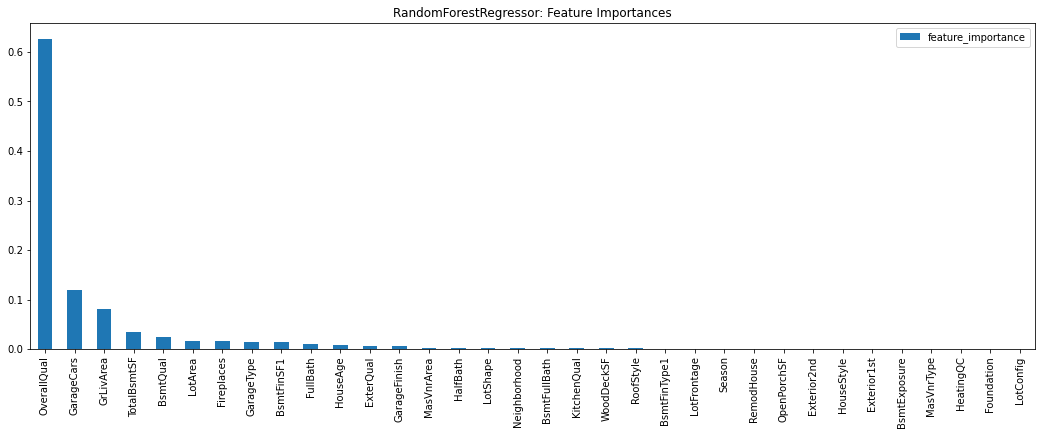

In [88]:
new_df.sort_values(by = 'feature_importance', ascending = False).plot.bar(figsize = (18, 6))
plt.title('RandomForestRegressor: Feature Importances')
plt.show()

In [89]:
new_df.sort_values(by = 'feature_importance', ascending = False)

,feature_importance
OverallQual,0.626898
GarageCars,0.118433
GrLivArea,0.080275
TotalBsmtSF,0.035412
BsmtQual,0.024650
LotArea,0.015804
Fireplaces,0.015691
GarageType,0.013886
BsmtFinSF1,0.013677
FullBath,0.009966


In [273]:
new_df.index

Index(['OverallQual', 'GarageCars', 'GrLivArea', 'TotalBsmtSF', 'BsmtQual',
       'LotArea', 'Fireplaces', 'GarageType', 'BsmtFinSF1', 'FullBath',
       'HouseAge', 'ExterQual', 'GarageFinish', 'MasVnrArea', 'HalfBath',
       'LotShape', 'Neighborhood', 'BsmtFullBath', 'KitchenQual', 'WoodDeckSF',
       'RoofStyle', 'BsmtFinType1', 'LotFrontage', 'Season', 'RemodHouse',
       'OpenPorchSF', 'Exterior2nd', 'HouseStyle', 'Exterior1st',
       'BsmtExposure', 'MasVnrType', 'HeatingQC', 'Foundation', 'LotConfig'],
      dtype='object')

In [311]:
X_train_rf = X_train.drop(['LotArea', 'Fireplaces', 'GarageType', 'BsmtFinSF1', 'FullBath',
       'HouseAge', 'ExterQual', 'GarageFinish','MasVnrArea', 'HalfBath',
       'LotShape', 'Neighborhood', 'BsmtFullBath', 'KitchenQual', 'WoodDeckSF',
       'RoofStyle', 'BsmtFinType1', 'LotFrontage', 'Season', 'RemodHouse',
       'OpenPorchSF', 'Exterior2nd', 'HouseStyle', 'Exterior1st',
       'BsmtExposure', 'MasVnrType', 'HeatingQC', 'Foundation', 'LotConfig'], axis = 1)
X_test_rf = X_test.drop(['LotArea', 'Fireplaces', 'GarageType', 'BsmtFinSF1', 'FullBath',
       'HouseAge', 'ExterQual', 'GarageFinish','MasVnrArea', 'HalfBath',
       'LotShape', 'Neighborhood', 'BsmtFullBath', 'KitchenQual', 'WoodDeckSF',
       'RoofStyle', 'BsmtFinType1', 'LotFrontage', 'Season', 'RemodHouse',
       'OpenPorchSF', 'Exterior2nd', 'HouseStyle', 'Exterior1st',
       'BsmtExposure', 'MasVnrType', 'HeatingQC', 'Foundation', 'LotConfig'], axis = 1)

In [329]:
X_train_rf.shape, X_test_rf.shape

((1022, 5), (438, 5))

In [330]:
numeric_vars_rf = [var for var in X_train_rf.columns if X_train_rf[var].dtypes != 'O'
               and var != 'SalePrice']

In [314]:
discrete_rf = [var for var in X_train_rf.columns if X_train_rf[var].dtype != 'O' 
            and var != 'SalePrice' and X_train_rf[var].nunique()<20]

In [331]:
num_list_rf = [var for var in numeric_vars_rf if var not in discrete_rf 
                and var not in ['Id', 'SalePrice']]

In [332]:
categorical_vars_rf = [var for var in X_train_rf.columns if X_train_rf[var].dtype == 'O']

In [333]:
cat_list_rf = categorical_vars_rf + discrete_rf

In [334]:
X_train_rf[cat_list_rf] = X_train_rf[cat_list_rf].astype('O')
X_test_rf[cat_list_rf] = X_test_rf[cat_list_rf].astype('O')

In [335]:
X_train_rf.shape, X_test_rf.shape

((1022, 5), (438, 5))

In [348]:
pipe_rfr1 = Pipeline(steps = [('imputer_num', MeanMedianImputer(imputation_method = 'mean', variables = num_list_rf)), 
                         ('imputer_cat', CategoricalImputer(imputation_method = 'missing', variables = cat_list_rf)), 
                         ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)), 
                         ('discretizer', EqualFrequencyDiscretiser(q = 5, return_object = True, variables = num_list_rf)), 
                         ('encoder', OneHotEncoder()), 
                         ('scaler', StandardScaler()), 
                         ('RF', RandomForestRegressor(n_estimators = 250, 
                                                      random_state = 0, 
                                                      criterion = 'absolute_error', 
                                                     min_samples_split = 0.01, 
                                                     min_samples_leaf = 0.01, 
                                                     max_depth = 4))])

In [349]:
pipe_rfr1.fit(X_train_rf, y_train)

Pipeline(steps=[('imputer_num',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['TotalBsmtSF', 'GrLivArea'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['OverallQual', 'BsmtQual',
                                               'GarageCars'])),
                ('rare_label', RareLabelEncoder(n_categories=3)),
                ('discretizer',
                 EqualFrequencyDiscretiser(q=5, return_object=True,
                                           variables=['TotalBsmtSF',
                                                      'GrLivArea'])),
                ('encoder', OneHotEncoder()), ('scaler', StandardScaler()),
                ('RF',
                 RandomForestRegressor(criterion='absolute_error', max_depth=4,
                                       min_samples_leaf=0.01,
                                       min_samples_split=0.01, n_estimators=250,
                                       random_state=0))])

In [350]:
X_train_preds1 = pipe_rfr1.predict(X_train_rf)
X_test_preds1 = pipe_rfr1.predict(X_test_rf)

In [351]:
print('train MAE: {}'.format(mean_absolute_error(y_train, X_train_preds1)))
print('train RMSE: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds1))))
print('train R2: {}'.format(r2_score(y_train, X_train_preds1)))
print()

print('test MAE: {}'.format(mean_absolute_error(y_test, X_test_preds1)))
print('test RMSE: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds1))))
print('test R2: {}'.format(r2_score(y_test, X_test_preds1)))

train MAE: 23583.344007827785
train RMSE: 36163.853415162164
train R2: 0.7855940058941089

test MAE: 23768.054328767124
test RMSE: 39573.415514418084
test R2: 0.7693243202476879


## [Decision Tree Regressor] Pipeline with best parameters

In [288]:
pipe_dtr = Pipeline(steps = [('imputer_num', MeanMedianImputer(imputation_method = 'mean', variables = num_list)), 
                         ('imputer_cat', CategoricalImputer(imputation_method = 'missing', variables = cat_list)), 
                         ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)), 
                         ('discretizer', EqualFrequencyDiscretiser(q = 6, return_object = False, variables = num_list)), 
                         ('encoder', OneHotEncoder()), 
                         ('scaler', StandardScaler()), 
                         ('DTR', DecisionTreeRegressor(random_state = 0, 
                                                      min_samples_split = 0.01,  
                                                      min_samples_leaf = 0.01, 
                                                      criterion = 'absolute_error', 
                                                      max_features = 'auto',
                                                      max_depth = 4))])

In [289]:
pipe_dtr.fit(X_train, y_train)

Pipeline(steps=[('imputer_num',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'LotArea',
                                              'MasVnrArea', 'BsmtFinSF1',
                                              'TotalBsmtSF', 'GrLivArea',
                                              'WoodDeckSF', 'OpenPorchSF',
                                              'HouseAge', 'RemodHouse'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['LotShape', 'LotConfig',
                                               'Neighborhood', 'HouseStyle',
                                               'RoofStyle', 'Exterior1st',
                                               'Exterior2nd'...
                 EqualFrequencyDiscretiser(q=6,
                                           variables=['LotFrontage', 'LotArea',
                                                      'MasVnrArea',
                                                      'BsmtFinSF1',
                                                      'TotalBsmtSF',
                                                      'GrLivArea', 'WoodDeckSF',
                                                      'OpenPorchSF', 'HouseAge',
                                                      'RemodHouse'])),
                ('encoder', OneHotEncoder()), ('scaler', StandardScaler()),
                ('DTR',
                 DecisionTreeRegressor(criterion='absolute_error', max_depth=4,
                                       max_features='auto',
                                       min_samples_leaf=0.01,
                                       min_samples_split=0.01,
                                       random_state=0))])

In [290]:
X_train_preds = pipe_dtr.predict(X_train)
X_test_preds = pipe_dtr.predict(X_test)

In [291]:
print('train MAE: {}'.format(mean_absolute_error(y_train, X_train_preds)))
print('train RMSE: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train R2: {}'.format(r2_score(y_train, X_train_preds)))
print()

print('test MAE: {}'.format(mean_absolute_error(y_test, X_test_preds)))
print('test RMSE: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test R2: {}'.format(r2_score(y_test, X_test_preds)))

train MAE: 24793.2759295499
train RMSE: 37287.950850780144
train R2: 0.7720578936323491

test MAE: 26211.46803652968
test RMSE: 42386.17598126857
test R2: 0.7353674798476093


### [Decision Tree Regressor] Feature importances

In [298]:
onehot_columns_dtr = list(pipe_dtr.named_steps['scaler'].feature_names_in_)
importance_dtr = pd.Series(pipe_dtr.named_steps['DTR'].feature_importances_)
importance_dtr.index = onehot_columns_dtr

In [299]:
len(onehot_columns_dtr)

97

In [300]:
onehot_columns_dtr

['LotFrontage',
 'LotArea',
 'OverallQual',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'Fireplaces',
 'GarageCars',
 'WoodDeckSF',
 'OpenPorchSF',
 'HouseAge',
 'RemodHouse',
 'LotShape_Reg',
 'LotShape_IR1',
 'LotShape_Rare',
 'LotConfig_Inside',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_Rare',
 'Neighborhood_CollgCr',
 'Neighborhood_Rare',
 'Neighborhood_Edwards',
 'Neighborhood_Sawyer',
 'Neighborhood_NAmes',
 'Neighborhood_Gilbert',
 'Neighborhood_Somerst',
 'Neighborhood_OldTown',
 'HouseStyle_2Story',
 'HouseStyle_1Story',
 'HouseStyle_1.5Fin',
 'HouseStyle_Rare',
 'RoofStyle_Gable',
 'RoofStyle_Hip',
 'RoofStyle_Rare',
 'Exterior1st_VinylSd',
 'Exterior1st_Wd Sdng',
 'Exterior1st_Rare',
 'Exterior1st_HdBoard',
 'Exterior1st_MetalSd',
 'Exterior1st_Plywood',
 'Exterior2nd_VinylSd',
 'Exterior2nd_Wd Sdng',
 'Exterior2nd_Plywood',
 'Exterior2nd_Rare',
 'Exterior2nd_HdBoard',
 'Exterior2nd_MetalSd',
 'MasVnrTy

In [301]:
importance_name = importance_dtr.rename(index = { 
 'LotShape_Reg': 'LotShape', 
 'LotShape_IR1': 'LotShape', 
 'LotShape_Rare': 'LotShape', 
 'LotConfig_Inside': 'LotConfig', 
 'LotConfig_Corner': 'LotConfig', 
 'LotConfig_CulDSac': 'LotConfig', 
 'LotConfig_Rare': 'LotConfig', 
 'Neighborhood_CollgCr': 'Neighborhood',
 'Neighborhood_Rare': 'Neighborhood',
 'Neighborhood_Edwards': 'Neighborhood',
 'Neighborhood_Sawyer': 'Neighborhood',
 'Neighborhood_NAmes': 'Neighborhood',
 'Neighborhood_Gilbert': 'Neighborhood',
 'Neighborhood_Somerst': 'Neighborhood',
 'Neighborhood_OldTown': 'Neighborhood',
 'HouseStyle_2Story': 'HouseStyle',
 'HouseStyle_1Story': 'HouseStyle',
 'HouseStyle_1.5Fin': 'HouseStyle',
 'HouseStyle_Rare': 'HouseStyle',
 'RoofStyle_Gable': 'RoofStyle',
 'RoofStyle_Hip': 'RoofStyle',
 'RoofStyle_Rare': 'RoofStyle',
 'Exterior1st_VinylSd': 'Exterior1st',
 'Exterior1st_Wd Sdng': 'Exterior1st',
 'Exterior1st_Rare': 'Exterior1st',
 'Exterior1st_HdBoard': 'Exterior1st',
 'Exterior1st_MetalSd': 'Exterior1st',
 'Exterior1st_Plywood': 'Exterior1st',
 'Exterior2nd_VinylSd': 'Exterior2nd',
 'Exterior2nd_Wd Sdng': 'Exterior2nd',
 'Exterior2nd_Plywood': 'Exterior2nd',
 'Exterior2nd_Rare': 'Exterior2nd',
 'Exterior2nd_HdBoard': 'Exterior2nd',
 'Exterior2nd_MetalSd': 'Exterior2nd',
 'MasVnrType_BrkFace': 'MasVnrType',
 'MasVnrType_None': 'MasVnrType',
 'MasVnrType_Stone': 'MasVnrType',
 'MasVnrType_Rare': 'MasVnrType',
 'ExterQual_TA': 'ExterQual',
 'ExterQual_Gd': 'ExterQual',
 'ExterQual_Rare': 'ExterQual',
 'Foundation_PConc': 'Foundation',
 'Foundation_CBlock': 'Foundation',
 'Foundation_BrkTil': 'Foundation',
 'Foundation_Rare': 'Foundation',
 'BsmtQual_Gd': 'BsmtQual',
 'BsmtQual_TA': 'BsmtQual',
 'BsmtQual_Rare': 'BsmtQual',
 'BsmtQual_Ex': 'BsmtQual',
 'BsmtExposure_No': 'BsmtExposure',
 'BsmtExposure_Mn': 'BsmtExposure',
 'BsmtExposure_Gd': 'BsmtExposure',
 'BsmtExposure_Rare': 'BsmtExposure',
 'BsmtExposure_Av': 'BsmtExposure',
 'BsmtFinType1_GLQ': 'BsmtFinType1',
 'BsmtFinType1_BLQ': 'BsmtFinType1',
 'BsmtFinType1_Rec': 'BsmtFinType1',
 'BsmtFinType1_ALQ': 'BsmtFinType1',
 'BsmtFinType1_Unf': 'BsmtFinType1',
 'BsmtFinType1_Rare': 'BsmtFinType1',
 'BsmtFinSF1_2': 'BsmtFinSF1',
 'BsmtFinSF1_3': 'BsmtFinSF1',
 'BsmtFinSF1_0': 'BsmtFinSF1',
 'BsmtFinSF1_1': 'BsmtFinSF1',
 'TotalBsmtSF_2': 'TotalBsmtSF',
 'TotalBsmtSF_3': 'TotalBsmtSF',
 'TotalBsmtSF_1': 'TotalBsmtSF',
 'TotalBsmtSF_0': 'TotalBsmtSF',
 'TotalBsmtSF_4': 'TotalBsmtSF',
 'HeatingQC_Ex': 'HeatingQC',
 'HeatingQC_Gd': 'HeatingQC',
 'HeatingQC_TA': 'HeatingQC',
 'HeatingQC_Rare': 'HeatingQC',
 'KitchenQual_Gd': 'KitchenQual',
 'KitchenQual_TA': 'KitchenQual',
 'KitchenQual_Rare': 'KitchenQual',
 'KitchenQual_Ex': 'KitchenQual',
 'GarageType_Attchd': 'GarageType',
 'GarageType_Missing': 'GarageType',
 'GarageType_Detchd': 'GarageType',
 'GarageType_Rare': 'GarageType',
 'GarageType_BuiltIn': 'GarageType',
 'GarageFinish_RFn': 'GarageFinish',
 'GarageFinish_Unf': 'GarageFinish',
 'GarageFinish_Missing': 'GarageFinish',
 'GarageFinish_Fin': 'GarageFinish',
 'Season_winter' : 'Season', 
 'Season_autumn': 'Season', 
 'Season_spring': 'Season', 
 'Season_summer': 'Season'
})  

In [302]:
len(importance_name)

97

In [303]:
dtr_df = importance_name.to_frame(name = 'feature_importance')

In [304]:
dtr_df.head(20)

,feature_importance
LotFrontage,0.000000
LotArea,0.000000
OverallQual,0.684703
MasVnrArea,0.000000
BsmtFinSF1,0.000000
TotalBsmtSF,0.069739
GrLivArea,0.119916
BsmtFullBath,0.000000
FullBath,0.000000
HalfBath,0.019790


In [305]:
dtr_df = dtr_df.groupby(level = 0).sum()

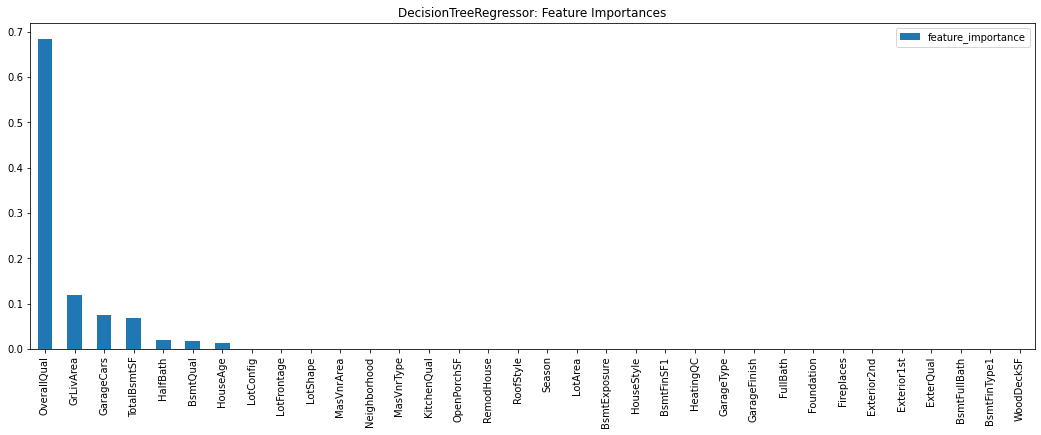

In [306]:
dtr_df.sort_values(by = 'feature_importance', ascending = False).plot.bar(figsize = (18, 6))
plt.title('DecisionTreeRegressor: Feature Importances')
plt.show()

In [309]:
dtr_df.sort_values(by = 'feature_importance', ascending = False)

,feature_importance
OverallQual,0.684703
GrLivArea,0.119916
GarageCars,0.074994
TotalBsmtSF,0.069739
HalfBath,0.019790
BsmtQual,0.017013
HouseAge,0.013845
LotConfig,0.000000
LotFrontage,0.000000
LotShape,0.000000


## [KNeighborsRegressor] Pipeline with best parameters

In [365]:
pipe_knn = Pipeline(steps = [('imputer_num', MeanMedianImputer(imputation_method = 'median', variables = num_list)), 
                         ('imputer_cat', CategoricalImputer(imputation_method = 'missing', variables = cat_list)), 
                         ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)), 
                         ('discretizer', EqualFrequencyDiscretiser(q = 6, return_object = True, variables = num_list)), 
                         ('encoder', OneHotEncoder()), 
                         ('scaler', StandardScaler()), 
                         ('KNN', KNeighborsRegressor(p = 2, metric = 'manhattan', algorithm = 'auto', leaf_size = 1, 
                                                           weights = 'uniform', n_neighbors = 3))])

In [366]:
pipe_knn.fit(X_train, y_train)

Pipeline(steps=[('imputer_num',
                 MeanMedianImputer(variables=['LotFrontage', 'LotArea',
                                              'MasVnrArea', 'BsmtFinSF1',
                                              'TotalBsmtSF', 'GrLivArea',
                                              'WoodDeckSF', 'OpenPorchSF',
                                              'HouseAge', 'RemodHouse'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['LotShape', 'LotConfig',
                                               'Neighborhood', 'HouseStyle',
                                               'RoofStyle', 'Exterior1st',
                                               'Exterior2nd', 'MasVnrType',
                                               'ExterQual'...
                ('rare_label', RareLabelEncoder(n_categories=3)),
                ('discretizer',
                 EqualFrequencyDiscretiser(q=6, return_object=True,
                                           variables=['LotFrontage', 'LotArea',
                                                      'MasVnrArea',
                                                      'BsmtFinSF1',
                                                      'TotalBsmtSF',
                                                      'GrLivArea', 'WoodDeckSF',
                                                      'OpenPorchSF', 'HouseAge',
                                                      'RemodHouse'])),
                ('encoder', OneHotEncoder()), ('scaler', StandardScaler()),
                ('KNN',
                 KNeighborsRegressor(leaf_size=1, metric='manhattan',
                                     n_neighbors=3))])

In [367]:
X_train_preds = pipe_knn.predict(X_train)
X_test_preds = pipe_knn.predict(X_test)

In [368]:
print('train MAE: {}'.format(mean_absolute_error(y_train, X_train_preds)))
print('train RMSE: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train R2: {}'.format(r2_score(y_train, X_train_preds)))
print()

print('test MAE: {}'.format(mean_absolute_error(y_test, X_test_preds)))
print('test RMSE: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test R2: {}'.format(r2_score(y_test, X_test_preds)))

train MAE: 16166.921395955642
train RMSE: 26428.55362787345
train R2: 0.8854923995470627

test MAE: 22367.680365296805
test RMSE: 36122.95959195325
test R2: 0.8077964568037839


## Scaling y

In [ ]:
y_train = y_train.to_numpy().reshape(-1, 1)
y_test = y_test.to_numpy().reshape(-1, 1)

In [393]:
scaler = StandardScaler()
y_train = scaler.fit_transform(y_train)
y_test = scaler.transform(y_test)

In [394]:
y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

In [395]:
y_train.shape, y_test.shape

((1022,), (438,))

## [SVR] Pipeline with best parameters

In [396]:
pipe_svr = Pipeline(steps = [('imputer_num', MeanMedianImputer(imputation_method = 'mean', variables = num_list)), 
                         ('imputer_cat', CategoricalImputer(imputation_method = 'missing', variables = cat_list)), 
                         ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)), 
                         ('discretizer', EqualFrequencyDiscretiser(q = 7, return_object = True, variables = num_list)), 
                         ('encoder', OneHotEncoder()), 
                         ('scaler', StandardScaler()), 
                         ('SVR', SVR(kernel = 'linear', gamma = 0.01, C = 1.0))
                            ])

In [397]:
pipe_svr.fit(X_train, y_train)

Pipeline(steps=[('imputer_num',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'LotArea',
                                              'MasVnrArea', 'BsmtFinSF1',
                                              'TotalBsmtSF', 'GrLivArea',
                                              'WoodDeckSF', 'OpenPorchSF',
                                              'HouseAge', 'RemodHouse'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['LotShape', 'LotConfig',
                                               'Neighborhood', 'HouseStyle',
                                               'RoofStyle', 'Exterior1st',
                                               'Exterior2nd'...
                ('rare_label', RareLabelEncoder(n_categories=3)),
                ('discretizer',
                 EqualFrequencyDiscretiser(q=7, return_object=True,
                                           variables=['LotFrontage', 'LotArea',
                                                      'MasVnrArea',
                                                      'BsmtFinSF1',
                                                      'TotalBsmtSF',
                                                      'GrLivArea', 'WoodDeckSF',
                                                      'OpenPorchSF', 'HouseAge',
                                                      'RemodHouse'])),
                ('encoder', OneHotEncoder()), ('scaler', StandardScaler()),
                ('SVR', SVR(gamma=0.01, kernel='linear'))])

In [399]:
X_train_svr = pipe_svr.predict(X_train)
X_test_svr = pipe_svr.predict(X_test)

In [400]:
X_train_svr = scaler.inverse_transform(X_train_svr.reshape(-1, 1))
X_test_svr = scaler.inverse_transform(X_test_svr.reshape(-1, 1))

In [401]:
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

In [402]:
print('train MAE: {}'.format(mean_absolute_error(y_train, X_train_svr1)))
print('train RMSE: {}'.format(sqrt(mean_squared_error(y_train, X_train_svr1))))
print('train R2: {}'.format(r2_score(y_train, X_train_svr1)))
print()

print('test MAE: {}'.format(mean_absolute_error(y_test, X_test_svr1)))
print('test RMSE: {}'.format(sqrt(mean_squared_error(y_test, X_test_svr1))))
print('test R2: {}'.format(r2_score(y_test, X_test_svr1)))

train MAE: 16939.59144558268
train RMSE: 28555.72375220504
train R2: 0.8663177131924188

test MAE: 19498.140177519617
test RMSE: 34150.71344499975
test R2: 0.828211415650711


### [SVR] Feature Importances

In [410]:
onehot_columns_svr = list(pipe_svr.named_steps['scaler'].feature_names_in_)
coef_svr = pd.Series(pipe_svr.named_steps['SVR'].coef_.reshape(-1))
coef_svr.index = onehot_columns_svr

In [413]:
coef_svr

OverallQual      0.226452
BsmtFullBath     0.041320
FullBath         0.075209
HalfBath         0.049017
Fireplaces       0.043872
                   ...   
RemodHouse_3    -0.003331
Season_winter   -0.012933
Season_autumn   -0.018019
Season_spring    0.004939
Season_summer    0.017191
Length: 144, dtype: float64

In [412]:
onehot_columns_svr

['OverallQual',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'Fireplaces',
 'GarageCars',
 'LotFrontage_2',
 'LotFrontage_0',
 'LotFrontage_1',
 'LotFrontage_3',
 'LotFrontage_4',
 'LotFrontage_5',
 'LotArea_3',
 'LotArea_0',
 'LotArea_1',
 'LotArea_2',
 'LotArea_5',
 'LotArea_4',
 'LotArea_6',
 'LotShape_Reg',
 'LotShape_IR1',
 'LotShape_Rare',
 'LotConfig_Inside',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_Rare',
 'Neighborhood_CollgCr',
 'Neighborhood_Rare',
 'Neighborhood_Edwards',
 'Neighborhood_Sawyer',
 'Neighborhood_NAmes',
 'Neighborhood_Gilbert',
 'Neighborhood_Somerst',
 'Neighborhood_OldTown',
 'HouseStyle_2Story',
 'HouseStyle_1Story',
 'HouseStyle_1.5Fin',
 'HouseStyle_Rare',
 'RoofStyle_Gable',
 'RoofStyle_Hip',
 'RoofStyle_Rare',
 'Exterior1st_VinylSd',
 'Exterior1st_Wd Sdng',
 'Exterior1st_Rare',
 'Exterior1st_HdBoard',
 'Exterior1st_MetalSd',
 'Exterior1st_Plywood',
 'Exterior2nd_VinylSd',
 'Exterior2nd_Wd Sdng',
 'Exterior2nd_Plywood',
 'Exterior2nd_Rare',

In [414]:
svr_coef_name = coef_svr.rename(index = {
 'LotFrontage_2': 'LotFrontage',
 'LotFrontage_0': 'LotFrontage',
 'LotFrontage_1': 'LotFrontage',
 'LotFrontage_3': 'LotFrontage',
 'LotFrontage_4': 'LotFrontage',
 'LotFrontage_5': 'LotFrontage',
 'LotArea_3': 'LotArea',
 'LotArea_0': 'LotArea',
 'LotArea_1': 'LotArea',
 'LotArea_2': 'LotArea',
 'LotArea_5': 'LotArea',
 'LotArea_4': 'LotArea',
 'LotArea_6': 'LotArea',
 'LotShape_Reg':'LotShape',
 'LotShape_IR1': 'LotShape',
 'LotShape_Rare': 'LotShape',
 'LotConfig_Inside': 'LotConfig',
 'LotConfig_Corner': 'LotConfig',
 'LotConfig_CulDSac': 'LotConfig',
 'LotConfig_Rare': 'LotConfig',
 'Neighborhood_CollgCr': 'Neighborhood',
 'Neighborhood_Rare': 'Neighborhood',
 'Neighborhood_Edwards': 'Neighborhood',
 'Neighborhood_Sawyer': 'Neighborhood',
 'Neighborhood_NAmes': 'Neighborhood',
 'Neighborhood_Gilbert': 'Neighborhood',
 'Neighborhood_Somerst': 'Neighborhood',
 'Neighborhood_OldTown': 'Neighborhood',
 'HouseStyle_2Story': 'HouseStyle',
 'HouseStyle_1Story': 'HouseStyle',
 'HouseStyle_1.5Fin': 'HouseStyle',
 'HouseStyle_Rare': 'HouseStyle',
 'RoofStyle_Gable': 'RoofStyle',
 'RoofStyle_Hip': 'RoofStyle',
 'RoofStyle_Rare': 'RoofStyle',
 'Exterior1st_VinylSd': 'Exterior1st',
 'Exterior1st_Wd Sdng': 'Exterior1st',
 'Exterior1st_Rare': 'Exterior1st',
 'Exterior1st_HdBoard': 'Exterior1st',
 'Exterior1st_MetalSd': 'Exterior1st',
 'Exterior1st_Plywood': 'Exterior1st',
 'Exterior2nd_VinylSd': 'Exterior2nd',
 'Exterior2nd_Wd Sdng': 'Exterior2nd',
 'Exterior2nd_Plywood': 'Exterior2nd',
 'Exterior2nd_Rare': 'Exterior2nd',
 'Exterior2nd_HdBoard': 'Exterior2nd',
 'Exterior2nd_MetalSd': 'Exterior2nd',
 'MasVnrType_BrkFace': 'MasVnrType',
 'MasVnrType_None': 'MasVnrType',
 'MasVnrType_Stone': 'MasVnrType',
 'MasVnrType_Rare': 'MasVnrType',
 'MasVnrArea_2': 'MasVnrArea',
 'MasVnrArea_0': 'MasVnrArea',
 'MasVnrArea_1': 'MasVnrArea',
 'ExterQual_TA': 'ExterQual',
 'ExterQual_Gd': 'ExterQual',
 'ExterQual_Rare': 'ExterQual',
 'Foundation_PConc': 'Foundation',
 'Foundation_CBlock': 'Foundation',
 'Foundation_BrkTil': 'Foundation',
 'Foundation_Rare': 'Foundation',
 'BsmtQual_Gd': 'BsmtQual',
 'BsmtQual_TA': 'BsmtQual',
 'BsmtQual_Rare': 'BsmtQual',
 'BsmtQual_Ex': 'BsmtQual',
 'BsmtExposure_No': 'BsmtExposure',
 'BsmtExposure_Mn': 'BsmtExposure',
 'BsmtExposure_Gd': 'BsmtExposure',
 'BsmtExposure_Rare': 'BsmtExposure',
 'BsmtExposure_Av': 'BsmtExposure',
 'BsmtFinType1_GLQ': 'BsmtFinType1',
 'BsmtFinType1_BLQ': 'BsmtFinType1',
 'BsmtFinType1_Rec': 'BsmtFinType1',
 'BsmtFinType1_ALQ': 'BsmtFinType1',
 'BsmtFinType1_Unf': 'BsmtFinType1',
 'BsmtFinType1_Rare': 'BsmtFinType1',
 'BsmtFinSF1_3': 'BsmtFinSF1',
 'BsmtFinSF1_4': 'BsmtFinSF1',
 'BsmtFinSF1_0': 'BsmtFinSF1',
 'BsmtFinSF1_1': 'BsmtFinSF1',
 'BsmtFinSF1_2': 'BsmtFinSF1',
 'TotalBsmtSF_4': 'TotalBsmtSF',
 'TotalBsmtSF_5': 'TotalBsmtSF',
 'TotalBsmtSF_2': 'TotalBsmtSF',
 'TotalBsmtSF_0': 'TotalBsmtSF',
 'TotalBsmtSF_3': 'TotalBsmtSF',
 'TotalBsmtSF_1': 'TotalBsmtSF',
 'TotalBsmtSF_6': 'TotalBsmtSF',
 'HeatingQC_Ex': 'HeatingQC',
 'HeatingQC_Gd': 'HeatingQC',
 'HeatingQC_TA': 'HeatingQC',
 'HeatingQC_Rare': 'HeatingQC',
 'GrLivArea_6': 'GrLivArea',
 'GrLivArea_2': 'GrLivArea',
 'GrLivArea_0': 'GrLivArea',
 'GrLivArea_3': 'GrLivArea',
 'GrLivArea_1': 'GrLivArea',
 'GrLivArea_4': 'GrLivArea',
 'GrLivArea_5': 'GrLivArea',
 'KitchenQual_Gd': 'KitchenQual',
 'KitchenQual_TA': 'KitchenQual',
 'KitchenQual_Rare': 'KitchenQual',
 'KitchenQual_Ex': 'KitchenQual',
 'GarageType_Attchd': 'GarageType',
 'GarageType_Missing': 'GarageType',
 'GarageType_Detchd': 'GarageType',
 'GarageType_Rare': 'GarageType',
 'GarageType_BuiltIn': 'GarageType',
 'GarageFinish_RFn': 'GarageFinish',
 'GarageFinish_Unf':'GarageFinish',
 'GarageFinish_Missing': 'GarageFinish',
 'GarageFinish_Fin': 'GarageFinish',
 'WoodDeckSF_3': 'WoodDeckSF',
 'WoodDeckSF_1': 'WoodDeckSF',
 'WoodDeckSF_0': 'WoodDeckSF',
 'WoodDeckSF_2': 'WoodDeckSF',
 'OpenPorchSF_0': 'WoodDeckSF',
 'OpenPorchSF_1': 'WoodDeckSF',
 'OpenPorchSF_3': 'WoodDeckSF',
 'OpenPorchSF_2': 'WoodDeckSF',
 'HouseAge_2': 'HouseAge',
 'HouseAge_5': 'HouseAge',
 'HouseAge_6': 'HouseAge',
 'HouseAge_4': 'HouseAge',
 'HouseAge_0': 'HouseAge',
 'HouseAge_3': 'HouseAge',
 'HouseAge_1': 'HouseAge',
 'RemodHouse_2': 'RemodHouse',
 'RemodHouse_0': 'RemodHouse',
 'RemodHouse_6': 'RemodHouse',
 'RemodHouse_4': 'RemodHouse',
 'RemodHouse_5': 'RemodHouse',
 'RemodHouse_1': 'RemodHouse',
 'RemodHouse_3': 'RemodHouse',
 'Season_winter' : 'Season', 
 'Season_autumn': 'Season', 
 'Season_spring': 'Season', 
 'Season_summer': 'Season'
})  

In [415]:
len(svr_coef_name)

144

In [416]:
svr_df = svr_coef_name.to_frame(name = 'feature_importance')

In [418]:
svr_df = svr_df.groupby(level = 0).sum()

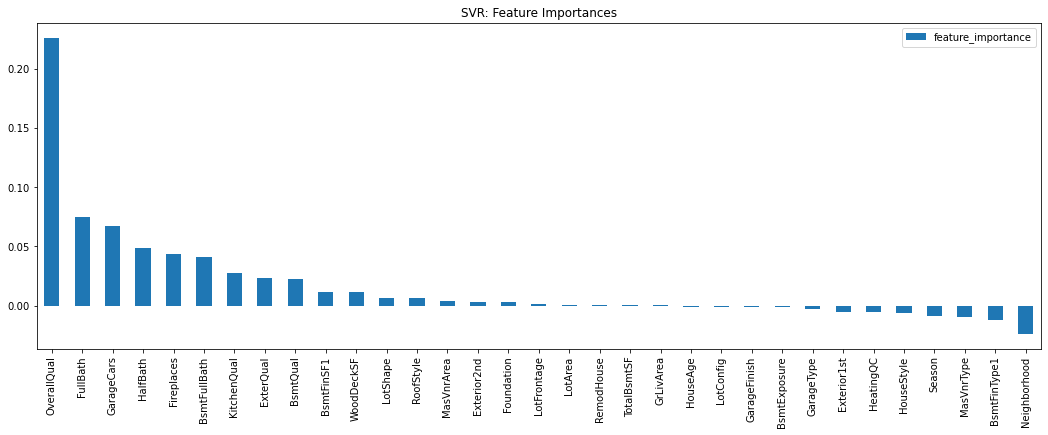

In [419]:
svr_df.sort_values(by = 'feature_importance', ascending = False).plot.bar(figsize = (18, 6))
plt.title('SVR: Feature Importances')
plt.show()

In [420]:
svr_df.sort_values(by = 'feature_importance', ascending = False)

,feature_importance
OverallQual,0.226452
FullBath,0.075209
GarageCars,0.067707
HalfBath,0.049017
Fireplaces,0.043872
BsmtFullBath,0.041320
KitchenQual,0.027920
ExterQual,0.023641
BsmtQual,0.022768
BsmtFinSF1,0.011750


## [XGBoost Regressor] Pipeline with best parameters

In [421]:
pipe_xgb = Pipeline(steps = [('imputer_num', MeanMedianImputer(imputation_method = 'mean', variables = num_list)), 
                         ('imputer_cat', CategoricalImputer(imputation_method = 'missing', variables = cat_list)), 
                         ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)), 
                         ('discretizer', EqualFrequencyDiscretiser(q = 6, return_object = False, variables = num_list)), 
                         ('encoder', OneHotEncoder()), 
                         ('scaler', StandardScaler()), 
                         ('XGB', XGBRegressor(random_state = 0, gamma = 0, 
                                              learning_rate = 0.01, 
                                              min_child_weight = 0.01, 
                                              max_depth = 2, 
                                              n_estimators = 400))])

In [422]:
pipe_xgb.fit(X_train, y_train)

Pipeline(steps=[('imputer_num',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'LotArea',
                                              'MasVnrArea', 'BsmtFinSF1',
                                              'TotalBsmtSF', 'GrLivArea',
                                              'WoodDeckSF', 'OpenPorchSF',
                                              'HouseAge', 'RemodHouse'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['LotShape', 'LotConfig',
                                               'Neighborhood', 'HouseStyle',
                                               'RoofStyle', 'Exterior1st',
                                               'Exterior2nd'...
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.01,
                              max_delta_step=0, max_depth=2,
                              min_child_weight=0.01, missing=nan,
                              monotone_constraints='()', n_estimators=400,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [423]:
X_train_preds = pipe_xgb.predict(X_train)
X_test_preds = pipe_xgb.predict(X_test)

In [424]:
print('train MAE: {}'.format(mean_absolute_error(y_train, X_train_preds)))
print('train RMSE: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train R2: {}'.format(r2_score(y_train, X_train_preds)))
print()

print('test MAE: {}'.format(mean_absolute_error(y_test, X_test_preds)))
print('test RMSE: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test R2: {}'.format(r2_score(y_test, X_test_preds)))

train MAE: 18736.487363931017
train RMSE: 28782.446153036613
train R2: 0.8641865054696191

test MAE: 20035.989297945205
test RMSE: 33659.95705822107
test R2: 0.8331132512076694


### [XGBoost Regressor] Feature importances

In [426]:
onehot_columns_xgb = list(pipe_dtr.named_steps['scaler'].feature_names_in_)
importance_xgb = pd.Series(pipe_xgb.named_steps['XGB'].feature_importances_)
importance_xgb.index = onehot_columns_xgb

In [429]:
onehot_columns_xgb

['LotFrontage',
 'LotArea',
 'OverallQual',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 'GrLivArea',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'Fireplaces',
 'GarageCars',
 'WoodDeckSF',
 'OpenPorchSF',
 'HouseAge',
 'RemodHouse',
 'LotShape_Reg',
 'LotShape_IR1',
 'LotShape_Rare',
 'LotConfig_Inside',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_Rare',
 'Neighborhood_CollgCr',
 'Neighborhood_Rare',
 'Neighborhood_Edwards',
 'Neighborhood_Sawyer',
 'Neighborhood_NAmes',
 'Neighborhood_Gilbert',
 'Neighborhood_Somerst',
 'Neighborhood_OldTown',
 'HouseStyle_2Story',
 'HouseStyle_1Story',
 'HouseStyle_1.5Fin',
 'HouseStyle_Rare',
 'RoofStyle_Gable',
 'RoofStyle_Hip',
 'RoofStyle_Rare',
 'Exterior1st_VinylSd',
 'Exterior1st_Wd Sdng',
 'Exterior1st_Rare',
 'Exterior1st_HdBoard',
 'Exterior1st_MetalSd',
 'Exterior1st_Plywood',
 'Exterior2nd_VinylSd',
 'Exterior2nd_Wd Sdng',
 'Exterior2nd_Plywood',
 'Exterior2nd_Rare',
 'Exterior2nd_HdBoard',
 'Exterior2nd_MetalSd',
 'MasVnrTy

In [430]:
xgb_feature_names = importance_xgb.rename(index = { 
 'LotShape_Reg': 'LotShape', 
 'LotShape_IR1': 'LotShape', 
 'LotShape_Rare': 'LotShape', 
 'LotConfig_Inside': 'LotConfig', 
 'LotConfig_Corner': 'LotConfig', 
 'LotConfig_CulDSac': 'LotConfig', 
 'LotConfig_Rare': 'LotConfig', 
 'Neighborhood_CollgCr': 'Neighborhood',
 'Neighborhood_Rare': 'Neighborhood',
 'Neighborhood_Edwards': 'Neighborhood',
 'Neighborhood_Sawyer': 'Neighborhood',
 'Neighborhood_NAmes': 'Neighborhood',
 'Neighborhood_Gilbert': 'Neighborhood',
 'Neighborhood_Somerst': 'Neighborhood',
 'Neighborhood_OldTown': 'Neighborhood',
 'HouseStyle_2Story': 'HouseStyle',
 'HouseStyle_1Story': 'HouseStyle',
 'HouseStyle_1.5Fin': 'HouseStyle',
 'HouseStyle_Rare': 'HouseStyle',
 'RoofStyle_Gable': 'RoofStyle',
 'RoofStyle_Hip': 'RoofStyle',
 'RoofStyle_Rare': 'RoofStyle',
 'Exterior1st_VinylSd': 'Exterior1st',
 'Exterior1st_Wd Sdng': 'Exterior1st',
 'Exterior1st_Rare': 'Exterior1st',
 'Exterior1st_HdBoard': 'Exterior1st',
 'Exterior1st_MetalSd': 'Exterior1st',
 'Exterior1st_Plywood': 'Exterior1st',
 'Exterior2nd_VinylSd': 'Exterior2nd',
 'Exterior2nd_Wd Sdng': 'Exterior2nd',
 'Exterior2nd_Plywood': 'Exterior2nd',
 'Exterior2nd_Rare': 'Exterior2nd',
 'Exterior2nd_HdBoard': 'Exterior2nd',
 'Exterior2nd_MetalSd': 'Exterior2nd',
 'MasVnrType_BrkFace': 'MasVnrType',
 'MasVnrType_None': 'MasVnrType',
 'MasVnrType_Stone': 'MasVnrType',
 'MasVnrType_Rare': 'MasVnrType',
 'ExterQual_TA': 'ExterQual',
 'ExterQual_Gd': 'ExterQual',
 'ExterQual_Rare': 'ExterQual',
 'Foundation_PConc': 'Foundation',
 'Foundation_CBlock': 'Foundation',
 'Foundation_BrkTil': 'Foundation',
 'Foundation_Rare': 'Foundation',
 'BsmtQual_Gd': 'BsmtQual',
 'BsmtQual_TA': 'BsmtQual',
 'BsmtQual_Rare': 'BsmtQual',
 'BsmtQual_Ex': 'BsmtQual',
 'BsmtExposure_No': 'BsmtExposure',
 'BsmtExposure_Mn': 'BsmtExposure',
 'BsmtExposure_Gd': 'BsmtExposure',
 'BsmtExposure_Rare': 'BsmtExposure',
 'BsmtExposure_Av': 'BsmtExposure',
 'BsmtFinType1_GLQ': 'BsmtFinType1',
 'BsmtFinType1_BLQ': 'BsmtFinType1',
 'BsmtFinType1_Rec': 'BsmtFinType1',
 'BsmtFinType1_ALQ': 'BsmtFinType1',
 'BsmtFinType1_Unf': 'BsmtFinType1',
 'BsmtFinType1_Rare': 'BsmtFinType1',
 'BsmtFinSF1_2': 'BsmtFinSF1',
 'BsmtFinSF1_3': 'BsmtFinSF1',
 'BsmtFinSF1_0': 'BsmtFinSF1',
 'BsmtFinSF1_1': 'BsmtFinSF1',
 'TotalBsmtSF_2': 'TotalBsmtSF',
 'TotalBsmtSF_3': 'TotalBsmtSF',
 'TotalBsmtSF_1': 'TotalBsmtSF',
 'TotalBsmtSF_0': 'TotalBsmtSF',
 'TotalBsmtSF_4': 'TotalBsmtSF',
 'HeatingQC_Ex': 'HeatingQC',
 'HeatingQC_Gd': 'HeatingQC',
 'HeatingQC_TA': 'HeatingQC',
 'HeatingQC_Rare': 'HeatingQC',
 'KitchenQual_Gd': 'KitchenQual',
 'KitchenQual_TA': 'KitchenQual',
 'KitchenQual_Rare': 'KitchenQual',
 'KitchenQual_Ex': 'KitchenQual',
 'GarageType_Attchd': 'GarageType',
 'GarageType_Missing': 'GarageType',
 'GarageType_Detchd': 'GarageType',
 'GarageType_Rare': 'GarageType',
 'GarageType_BuiltIn': 'GarageType',
 'GarageFinish_RFn': 'GarageFinish',
 'GarageFinish_Unf': 'GarageFinish',
 'GarageFinish_Missing': 'GarageFinish',
 'GarageFinish_Fin': 'GarageFinish',
 'Season_winter' : 'Season', 
 'Season_autumn': 'Season', 
 'Season_spring': 'Season', 
 'Season_summer': 'Season'
})  

In [431]:
xgb_df = xgb_feature_names.to_frame(name = 'feature_importance')

In [432]:
xgb_df.head(20)

,feature_importance
LotFrontage,0.024884
LotArea,0.028215
OverallQual,0.230860
MasVnrArea,0.000000
BsmtFinSF1,0.029997
TotalBsmtSF,0.043606
GrLivArea,0.092113
BsmtFullBath,0.004037
FullBath,0.024960
HalfBath,0.024705


In [433]:
xgb_df = xgb_df.groupby(level = 0).sum()

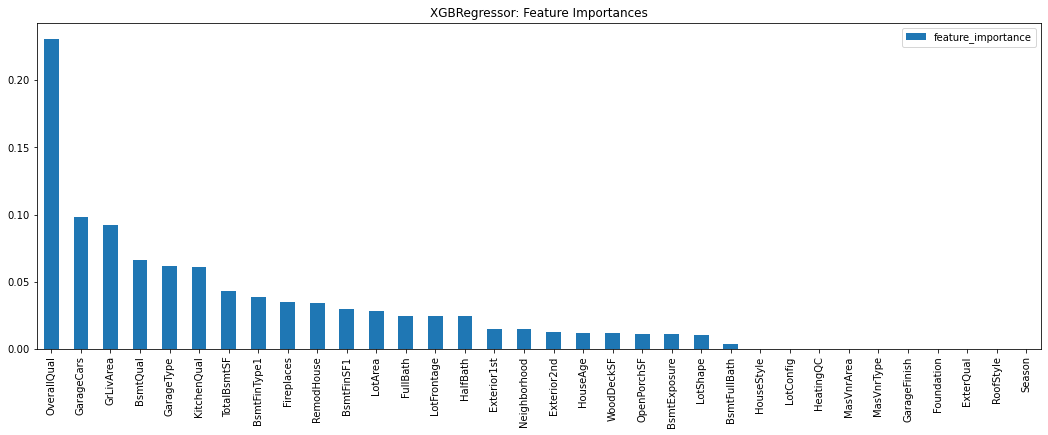

In [434]:
xgb_df.sort_values(by = 'feature_importance', ascending = False).plot.bar(figsize = (18, 6))
plt.title('XGBRegressor: Feature Importances')
plt.show()

In [435]:
xgb_df.sort_values(by = 'feature_importance', ascending = False)

,feature_importance
OverallQual,0.230860
GarageCars,0.098422
GrLivArea,0.092113
BsmtQual,0.066534
GarageType,0.061468
KitchenQual,0.061156
TotalBsmtSF,0.043606
BsmtFinType1,0.039053
Fireplaces,0.035029
RemodHouse,0.034664


## [Lasso] Pipeline with best parameters

In [92]:
pipe_lasso = Pipeline(steps = [('imputer_num', MeanMedianImputer(imputation_method = 'mean', variables = num_list)), 
                         ('imputer_cat', CategoricalImputer(imputation_method = 'missing', variables = cat_list)), 
                         ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)), 
                         ('discretizer', EqualFrequencyDiscretiser(q = 12, return_object = True, variables = num_list)), 
                         ('encoder', OneHotEncoder()), 
                         ('scaler', StandardScaler()), 
                         ('Lasso', Lasso(random_state = 0, alpha = 0.01, max_iter = 1000))])

In [93]:
pipe_lasso.fit(X_train, y_train)

Pipeline(steps=[('imputer_num',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'LotArea',
                                              'MasVnrArea', 'BsmtFinSF1',
                                              'TotalBsmtSF', 'GrLivArea',
                                              'WoodDeckSF', 'OpenPorchSF',
                                              'HouseAge', 'RemodHouse'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['LotShape', 'LotConfig',
                                               'Neighborhood', 'HouseStyle',
                                               'RoofStyle', 'Exterior1st',
                                               'Exterior2nd'...
                                               'FullBath', 'HalfBath',
                                               'Fireplaces', 'GarageCars'])),
                ('rare_label', RareLabelEncoder(n_categories=3)),
                ('discretizer',
                 EqualFrequencyDiscretiser(q=12, return_object=True,
                                           variables=['LotFrontage', 'LotArea',
                                                      'MasVnrArea',
                                                      'BsmtFinSF1',
                                                      'TotalBsmtSF',
                                                      'GrLivArea', 'WoodDeckSF',
                                                      'OpenPorchSF', 'HouseAge',
                                                      'RemodHouse'])),
                ('encoder', OneHotEncoder()), ('scaler', StandardScaler())])

In [42]:
X_train_preds = pipe_lasso.predict(X_train)
X_test_preds = pipe_lasso.predict(X_test)

In [43]:
print('train MAE: {}'.format(mean_absolute_error(y_train, X_train_preds)))
print('train RMSE: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train R2: {}'.format(r2_score(y_train, X_train_preds)))
print()

print('test MAE: {}'.format(mean_absolute_error(y_test, X_test_preds)))
print('test RMSE: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test R2: {}'.format(r2_score(y_test, X_test_preds)))

train MAE: 16741.242760013967
train RMSE: 25824.934108409616
train R2: 0.8906632988545142

test MAE: 20724.17474771137
test RMSE: 34277.17730448391
test R2: 0.8269367557493409


### [Lasso] Feature Importances

In [440]:
onehot_columns_ls = list(pipe_lasso.named_steps['scaler'].feature_names_in_)
coef_lasso = pd.Series(pipe_lasso.named_steps['Lasso'].coef_.reshape(-1))
coef_lasso.index = onehot_columns_ls

In [441]:
onehot_columns_ls

['OverallQual',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'Fireplaces',
 'GarageCars',
 'LotFrontage_4',
 'LotFrontage_1',
 'LotFrontage_2',
 'LotFrontage_5',
 'LotFrontage_0',
 'LotFrontage_6',
 'LotFrontage_9',
 'LotFrontage_7',
 'LotFrontage_3',
 'LotFrontage_8',
 'LotArea_5',
 'LotArea_0',
 'LotArea_2',
 'LotArea_3',
 'LotArea_1',
 'LotArea_9',
 'LotArea_6',
 'LotArea_4',
 'LotArea_7',
 'LotArea_10',
 'LotArea_11',
 'LotArea_8',
 'LotShape_Reg',
 'LotShape_IR1',
 'LotShape_Rare',
 'LotConfig_Inside',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_Rare',
 'Neighborhood_CollgCr',
 'Neighborhood_Rare',
 'Neighborhood_Edwards',
 'Neighborhood_Sawyer',
 'Neighborhood_NAmes',
 'Neighborhood_Gilbert',
 'Neighborhood_Somerst',
 'Neighborhood_OldTown',
 'HouseStyle_2Story',
 'HouseStyle_1Story',
 'HouseStyle_1.5Fin',
 'HouseStyle_Rare',
 'RoofStyle_Gable',
 'RoofStyle_Hip',
 'RoofStyle_Rare',
 'Exterior1st_VinylSd',
 'Exterior1st_Wd Sdng',
 'Exterior1st_Rare',
 'Exterior1st_HdBoar

In [456]:
lasso_coef_name = coef_lasso.rename(index = {
 'LotFrontage_4': 'LotFrontage',
 'LotFrontage_1': 'LotFrontage',
 'LotFrontage_2': 'LotFrontage',
 'LotFrontage_5': 'LotFrontage',
 'LotFrontage_0': 'LotFrontage',
 'LotFrontage_6': 'LotFrontage',
 'LotFrontage_9': 'LotFrontage',
 'LotFrontage_7': 'LotFrontage',
 'LotFrontage_3': 'LotFrontage',
 'LotFrontage_8': 'LotFrontage',
 'LotArea_5': 'LotArea',
 'LotArea_0': 'LotArea',
 'LotArea_2': 'LotArea',
 'LotArea_3': 'LotArea',
 'LotArea_1': 'LotArea',
 'LotArea_9': 'LotArea',
 'LotArea_6': 'LotArea',
 'LotArea_4': 'LotArea',
 'LotArea_7': 'LotArea',
 'LotArea_10': 'LotArea',
 'LotArea_11': 'LotArea',
 'LotArea_8': 'LotArea',
 'LotShape_Reg': 'LotShape',
 'LotShape_IR1': 'LotShape',
 'LotShape_Rare': 'LotShape',
 'LotConfig_Inside': 'LotConfig',
 'LotConfig_Corner': 'LotConfig',
 'LotConfig_CulDSac': 'LotConfig',
 'LotConfig_Rare': 'LotConfig',
 'Neighborhood_CollgCr': 'Neighborhood',
 'Neighborhood_Rare': 'Neighborhood',
 'Neighborhood_Edwards': 'Neighborhood',
 'Neighborhood_Sawyer': 'Neighborhood',
 'Neighborhood_NAmes': 'Neighborhood',
 'Neighborhood_Gilbert': 'Neighborhood',
 'Neighborhood_Somerst': 'Neighborhood',
 'Neighborhood_OldTown': 'Neighborhood',
 'HouseStyle_2Story': 'HouseStyle',
 'HouseStyle_1Story': 'HouseStyle',
 'HouseStyle_1.5Fin': 'HouseStyle',
 'HouseStyle_Rare': 'HouseStyle',
 'RoofStyle_Gable': 'RoofStyle',
 'RoofStyle_Hip': 'RoofStyle',
 'RoofStyle_Rare': 'RoofStyle',
 'Exterior1st_VinylSd': 'Exterior1st',
 'Exterior1st_Wd Sdng': 'Exterior1st',
 'Exterior1st_Rare': 'Exterior1st',
 'Exterior1st_HdBoard': 'Exterior1st',
 'Exterior1st_MetalSd': 'Exterior1st',
 'Exterior1st_Plywood': 'Exterior1st',
 'Exterior2nd_VinylSd': 'Exterior2nd',
 'Exterior2nd_Wd Sdng': 'Exterior2nd',
 'Exterior2nd_Plywood': 'Exterior2nd',
 'Exterior2nd_Rare': 'Exterior2nd',
 'Exterior2nd_HdBoard': 'Exterior2nd',
 'Exterior2nd_MetalSd': 'Exterior2nd',
 'MasVnrType_BrkFace': 'MasVnrType',
 'MasVnrType_None': 'MasVnrType',
 'MasVnrType_Stone': 'MasVnrType',
 'MasVnrType_Rare': 'MasVnrType',
 'MasVnrArea_4': 'MasVnrArea',
 'MasVnrArea_0': 'MasVnrArea',
 'MasVnrArea_2': 'MasVnrArea',
 'MasVnrArea_1': 'MasVnrArea',
 'MasVnrArea_3': 'MasVnrArea',
 'ExterQual_TA': 'ExterQual',
 'ExterQual_Gd': 'ExterQual',
 'ExterQual_Rare': 'ExterQual',
 'Foundation_PConc': 'Foundation',
 'Foundation_CBlock': 'Foundation',
 'Foundation_BrkTil': 'Foundation',
 'Foundation_Rare': 'Foundation',
 'BsmtQual_Gd': 'BsmtQual',
 'BsmtQual_TA': 'BsmtQual',
 'BsmtQual_Rare': 'BsmtQual',
 'BsmtQual_Ex': 'BsmtQual',
 'BsmtExposure_No': 'BsmtExposure',
 'BsmtExposure_Mn': 'BsmtExposure',
 'BsmtExposure_Gd': 'BsmtExposure',
 'BsmtExposure_Rare': 'BsmtExposure',
 'BsmtExposure_Av': 'BsmtExposure',
 'BsmtFinType1_GLQ': 'BsmtFinType1',
 'BsmtFinType1_BLQ': 'BsmtFinType1',
 'BsmtFinType1_Rec': 'BsmtFinType1',
 'BsmtFinType1_ALQ': 'BsmtFinType1',
 'BsmtFinType1_Unf': 'BsmtFinType1',
 'BsmtFinType1_Rare': 'BsmtFinType1',
 'BsmtFinSF1_6': 'BsmtFinSF1',
 'BsmtFinSF1_7': 'BsmtFinSF1',
 'BsmtFinSF1_5': 'BsmtFinSF1',
 'BsmtFinSF1_1': 'BsmtFinSF1',
 'BsmtFinSF1_2': 'BsmtFinSF1',
 'BsmtFinSF1_0': 'BsmtFinSF1',
 'BsmtFinSF1_4': 'BsmtFinSF1',
 'BsmtFinSF1_3': 'BsmtFinSF1',
 'BsmtFinSF1_8': 'BsmtFinSF1',
 'TotalBsmtSF_6': 'TotalBsmtSF',
 'TotalBsmtSF_9': 'TotalBsmtSF',
 'TotalBsmtSF_3': 'TotalBsmtSF',
 'TotalBsmtSF_0': 'TotalBsmtSF',
 'TotalBsmtSF_1': 'TotalBsmtSF',
 'TotalBsmtSF_4': 'TotalBsmtSF',
 'TotalBsmtSF_7': 'TotalBsmtSF',
 'TotalBsmtSF_5': 'TotalBsmtSF',
 'TotalBsmtSF_10': 'TotalBsmtSF',
 'TotalBsmtSF_2': 'TotalBsmtSF',
 'TotalBsmtSF_8': 'TotalBsmtSF',
 'TotalBsmtSF_11': 'TotalBsmtSF',
 'HeatingQC_Ex': 'HeatingQC',
 'HeatingQC_Gd': 'HeatingQC',
 'HeatingQC_TA': 'HeatingQC',
 'HeatingQC_Rare': 'HeatingQC',
 'GrLivArea_10': 'GrLivArea',
 'GrLivArea_4': 'GrLivArea',
 'GrLivArea_0': 'GrLivArea',
 'GrLivArea_5': 'GrLivArea',
 'GrLivArea_1': 'GrLivArea',
 'GrLivArea_2': 'GrLivArea',
 'GrLivArea_7': 'GrLivArea',
 'GrLivArea_11': 'GrLivArea',
 'GrLivArea_9': 'GrLivArea',
 'GrLivArea_8': 'GrLivArea',
 'GrLivArea_6': 'GrLivArea',
 'GrLivArea_3': 'GrLivArea',
 'KitchenQual_Gd': 'KitchenQual',
 'KitchenQual_TA': 'KitchenQual',
 'KitchenQual_Rare': 'KitchenQual',
 'KitchenQual_Ex': 'KitchenQual',
 'GarageType_Attchd': 'GarageType',
 'GarageType_Missing': 'GarageType',
 'GarageType_Detchd': 'GarageType',
 'GarageType_Rare': 'GarageType',
 'GarageType_BuiltIn': 'GarageType',
 'GarageFinish_RFn': 'GarageFinish',
 'GarageFinish_Unf': 'GarageFinish',
 'GarageFinish_Missing': 'GarageFinish',
 'GarageFinish_Fin': 'GarageFinish',
 'WoodDeckSF_5': 'WoodDeckSF',
 'WoodDeckSF_1': 'WoodDeckSF',
 'WoodDeckSF_0': 'WoodDeckSF',
 'WoodDeckSF_3': 'WoodDeckSF',
 'WoodDeckSF_2': 'WoodDeckSF',
 'WoodDeckSF_4': 'WoodDeckSF',
 'OpenPorchSF_1': 'OpenPorchSF',
 'OpenPorchSF_0': 'OpenPorchSF',
 'OpenPorchSF_3': 'OpenPorchSF',
 'OpenPorchSF_5': 'OpenPorchSF',
 'OpenPorchSF_6': 'OpenPorchSF',
 'OpenPorchSF_2': 'OpenPorchSF',
 'OpenPorchSF_4': 'OpenPorchSF',
 'HouseAge_3': 'HouseAge',
 'HouseAge_8': 'HouseAge',
 'HouseAge_10': 'HouseAge',
 'HouseAge_11': 'HouseAge',
 'HouseAge_4': 'HouseAge',
 'HouseAge_9': 'HouseAge',
 'HouseAge_7': 'HouseAge',
 'HouseAge_1': 'HouseAge',
 'HouseAge_6': 'HouseAge',
 'HouseAge_0': 'HouseAge',
 'HouseAge_5': 'HouseAge',
 'HouseAge_2': 'HouseAge',
 'RemodHouse_5': 'RemodHouse',
 'RemodHouse_1': 'RemodHouse',
 'RemodHouse_11': 'RemodHouse',
 'RemodHouse_7': 'RemodHouse',
 'RemodHouse_10': 'RemodHouse',
 'RemodHouse_9': 'RemodHouse',
 'RemodHouse_2': 'RemodHouse',
 'RemodHouse_4': 'RemodHouse',
 'RemodHouse_8': 'RemodHouse',
 'RemodHouse_0': 'RemodHouse',
 'RemodHouse_6': 'RemodHouse',
 'RemodHouse_3': 'RemodHouse',
 'Season_winter': 'Season',
 'Season_autumn': 'Season',  
 'Season_spring': 'Season',
 'Season_summer': 'Season'
})

In [457]:
lasso_df = lasso_coef_name.to_frame(name = 'feature_importance')

In [458]:
lasso_df.head(10)

,feature_importance
OverallQual,17877.773318
BsmtFullBath,1927.027260
FullBath,7411.409008
HalfBath,5270.403588
Fireplaces,5345.406963
GarageCars,6417.894016
LotFrontage,-1.986722
LotFrontage,-2083.547246
LotFrontage,-1206.723350
LotFrontage,436.729404


In [459]:
lasso_df = lasso_df.groupby(level = 0).sum()

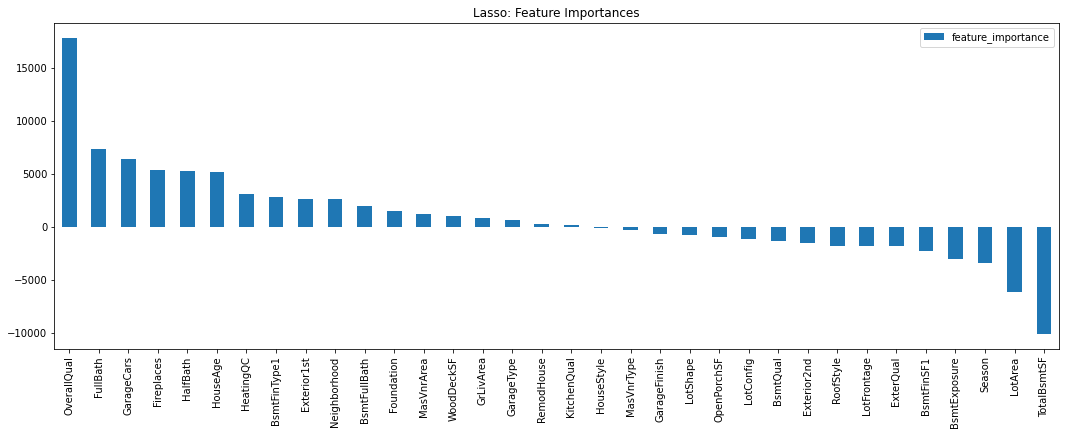

In [460]:
lasso_df.sort_values(by = 'feature_importance', ascending = False).plot.bar(figsize = (18, 6))
plt.title('Lasso: Feature Importances')
plt.show()

In [461]:
lasso_df.sort_values(by = 'feature_importance', ascending = False)

,feature_importance
OverallQual,17877.773318
FullBath,7411.409008
GarageCars,6417.894016
Fireplaces,5345.406963
HalfBath,5270.403588
HouseAge,5223.138282
HeatingQC,3078.357521
BsmtFinType1,2844.011688
Exterior1st,2666.808363
Neighborhood,2635.627971


## [BayesianRidge] Pipeline with best parameters

In [462]:
pipe_bayesian = Pipeline(steps = [('imputer_num', MeanMedianImputer(imputation_method = 'mean', variables = num_list)), 
                         ('imputer_cat', CategoricalImputer(imputation_method = 'missing', variables = cat_list)), 
                         ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)), 
                         ('discretizer', EqualFrequencyDiscretiser(q = 6, return_object = True, variables = num_list)), 
                         ('encoder', OneHotEncoder()), 
                         ('scaler', StandardScaler()), 
                         ('bayesian', BayesianRidge(n_iter=100))])

In [463]:
pipe_bayesian.fit(X_train, y_train)

Pipeline(steps=[('imputer_num',
                 MeanMedianImputer(imputation_method='mean',
                                   variables=['LotFrontage', 'LotArea',
                                              'MasVnrArea', 'BsmtFinSF1',
                                              'TotalBsmtSF', 'GrLivArea',
                                              'WoodDeckSF', 'OpenPorchSF',
                                              'HouseAge', 'RemodHouse'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['LotShape', 'LotConfig',
                                               'Neighborhood', 'HouseStyle',
                                               'RoofStyle', 'Exterior1st',
                                               'Exterior2nd'...
                                               'Fireplaces', 'GarageCars'])),
                ('rare_label', RareLabelEncoder(n_categories=3)),
                ('discretizer',
                 EqualFrequencyDiscretiser(q=6, return_object=True,
                                           variables=['LotFrontage', 'LotArea',
                                                      'MasVnrArea',
                                                      'BsmtFinSF1',
                                                      'TotalBsmtSF',
                                                      'GrLivArea', 'WoodDeckSF',
                                                      'OpenPorchSF', 'HouseAge',
                                                      'RemodHouse'])),
                ('encoder', OneHotEncoder()), ('scaler', StandardScaler()),
                ('bayesian', BayesianRidge(n_iter=100))])

In [464]:
X_train_preds = pipe_bayesian.predict(X_train)
X_test_preds = pipe_bayesian.predict(X_test)

In [465]:
print('train MAE: {}'.format(mean_absolute_error(y_train, X_train_preds)))
print('train RMSE: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train R2: {}'.format(r2_score(y_train, X_train_preds)))
print()

print('test MAE: {}'.format(mean_absolute_error(y_test, X_test_preds)))
print('test RMSE: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test R2: {}'.format(r2_score(y_test, X_test_preds)))

train MAE: 17962.80975339066
train RMSE: 27728.242338641794
train R2: 0.8739530897918456

test MAE: 20765.084037346078
test RMSE: 34851.53841911989
test R2: 0.821088339742098


### [BayesianRidge] Feature importances

In [466]:
onehot_columns_bs = list(pipe_bayesian.named_steps['scaler'].feature_names_in_)
coef_bs = pd.Series(pipe_bayesian.named_steps['bayesian'].coef_.reshape(-1))
coef_bs.index = onehot_columns_bs

In [468]:
coef_bs

OverallQual      16432.963978
BsmtFullBath      2167.572959
FullBath          7695.816299
HalfBath          4865.131133
Fireplaces        5707.947802
                     ...     
RemodHouse_1       553.279609
Season_winter      -37.910154
Season_autumn    -2525.196166
Season_spring      547.036422
Season_summer     1401.867573
Length: 138, dtype: float64

In [467]:
onehot_columns_bs

['OverallQual',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'Fireplaces',
 'GarageCars',
 'LotFrontage_2',
 'LotFrontage_0',
 'LotFrontage_1',
 'LotFrontage_3',
 'LotFrontage_4',
 'LotFrontage_5',
 'LotArea_2',
 'LotArea_0',
 'LotArea_1',
 'LotArea_4',
 'LotArea_3',
 'LotArea_5',
 'LotShape_Reg',
 'LotShape_IR1',
 'LotShape_Rare',
 'LotConfig_Inside',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_Rare',
 'Neighborhood_CollgCr',
 'Neighborhood_Rare',
 'Neighborhood_Edwards',
 'Neighborhood_Sawyer',
 'Neighborhood_NAmes',
 'Neighborhood_Gilbert',
 'Neighborhood_Somerst',
 'Neighborhood_OldTown',
 'HouseStyle_2Story',
 'HouseStyle_1Story',
 'HouseStyle_1.5Fin',
 'HouseStyle_Rare',
 'RoofStyle_Gable',
 'RoofStyle_Hip',
 'RoofStyle_Rare',
 'Exterior1st_VinylSd',
 'Exterior1st_Wd Sdng',
 'Exterior1st_Rare',
 'Exterior1st_HdBoard',
 'Exterior1st_MetalSd',
 'Exterior1st_Plywood',
 'Exterior2nd_VinylSd',
 'Exterior2nd_Wd Sdng',
 'Exterior2nd_Plywood',
 'Exterior2nd_Rare',
 'Exterior2nd

In [476]:
bs_coef_names = coef_bs.rename(index = {
 'LotFrontage_2': 'LotFrontage',
 'LotFrontage_0': 'LotFrontage',
 'LotFrontage_1': 'LotFrontage',
 'LotFrontage_3': 'LotFrontage',
 'LotFrontage_4': 'LotFrontage',
 'LotFrontage_5': 'LotFrontage',
 'LotArea_2': 'LotArea',
 'LotArea_0': 'LotArea',
 'LotArea_1': 'LotArea',
 'LotArea_4': 'LotArea',
 'LotArea_3': 'LotArea',
 'LotArea_5': 'LotArea',
 'LotShape_Reg': 'LotShape', 
 'LotShape_IR1': 'LotShape', 
 'LotShape_Rare': 'LotShape', 
 'LotConfig_Inside': 'LotConfig', 
 'LotConfig_Corner': 'LotConfig', 
 'LotConfig_CulDSac': 'LotConfig', 
 'LotConfig_Rare': 'LotConfig', 
 'Neighborhood_CollgCr': 'Neighborhood',
 'Neighborhood_Rare': 'Neighborhood',
 'Neighborhood_Edwards': 'Neighborhood',
 'Neighborhood_Sawyer': 'Neighborhood',
 'Neighborhood_NAmes': 'Neighborhood',
 'Neighborhood_Gilbert': 'Neighborhood',
 'Neighborhood_Somerst': 'Neighborhood',
 'Neighborhood_OldTown': 'Neighborhood',
 'HouseStyle_2Story': 'HouseStyle',
 'HouseStyle_1Story': 'HouseStyle',
 'HouseStyle_1.5Fin': 'HouseStyle',
 'HouseStyle_Rare': 'HouseStyle',
 'RoofStyle_Gable': 'RoofStyle',
 'RoofStyle_Hip': 'RoofStyle',
 'RoofStyle_Rare': 'RoofStyle',
 'Exterior1st_VinylSd': 'Exterior1st',
 'Exterior1st_Wd Sdng': 'Exterior1st',
 'Exterior1st_Rare': 'Exterior1st',
 'Exterior1st_HdBoard': 'Exterior1st',
 'Exterior1st_MetalSd': 'Exterior1st',
 'Exterior1st_Plywood': 'Exterior1st',
 'Exterior2nd_VinylSd': 'Exterior2nd',
 'Exterior2nd_Wd Sdng': 'Exterior2nd',
 'Exterior2nd_Plywood': 'Exterior2nd',
 'Exterior2nd_Rare': 'Exterior2nd',
 'Exterior2nd_HdBoard': 'Exterior2nd',
 'Exterior2nd_MetalSd': 'Exterior2nd',
 'MasVnrType_BrkFace': 'MasVnrType',
 'MasVnrType_None': 'MasVnrType',
 'MasVnrType_Stone': 'MasVnrType',
 'MasVnrType_Rare': 'MasVnrType',
 'MasVnrArea_2': 'MasVnrArea',
 'MasVnrArea_0': 'MasVnrArea',
 'MasVnrArea_1': 'MasVnrArea',
 'ExterQual_TA': 'ExterQual',
 'ExterQual_Gd': 'ExterQual',
 'ExterQual_Rare': 'ExterQual',
 'Foundation_PConc': 'Foundation',
 'Foundation_CBlock': 'Foundation',
 'Foundation_BrkTil': 'Foundation',
 'Foundation_Rare': 'Foundation',
 'BsmtQual_Gd': 'BsmtQual',
 'BsmtQual_TA': 'BsmtQual',
 'BsmtQual_Rare': 'BsmtQual',
 'BsmtQual_Ex': 'BsmtQual',
 'BsmtExposure_No': 'BsmtExposure',
 'BsmtExposure_Mn': 'BsmtExposure',
 'BsmtExposure_Gd': 'BsmtExposure',
 'BsmtExposure_Rare': 'BsmtExposure',
 'BsmtExposure_Av': 'BsmtExposure',
 'BsmtFinType1_GLQ': 'BsmtFinType1',
 'BsmtFinType1_BLQ': 'BsmtFinType1',
 'BsmtFinType1_Rec': 'BsmtFinType1',
 'BsmtFinType1_ALQ': 'BsmtFinType1',
 'BsmtFinType1_Unf': 'BsmtFinType1',
 'BsmtFinType1_Rare': 'BsmtFinType1',
 'BsmtFinSF1_2': 'BsmtFinSF1',
 'BsmtFinSF1_3': 'BsmtFinSF1',
 'BsmtFinSF1_0': 'BsmtFinSF1',
 'BsmtFinSF1_1': 'BsmtFinSF1',
 'BsmtFinSF1_4': 'BsmtFinSF1',
 'TotalBsmtSF_2': 'TotalBsmtSF',
 'TotalBsmtSF_3': 'TotalBsmtSF',
 'TotalBsmtSF_1': 'TotalBsmtSF',
 'TotalBsmtSF_0': 'TotalBsmtSF',
 'TotalBsmtSF_4': 'TotalBsmtSF',
 'TotalBsmtSF_5': 'TotalBsmtSF',
 'HeatingQC_Ex': 'HeatingQC',
 'HeatingQC_Gd': 'HeatingQC',
 'HeatingQC_TA': 'HeatingQC',
 'HeatingQC_Rare': 'HeatingQC',
 'GrLivArea_5': 'GrLivArea',
 'GrLivArea_2': 'GrLivArea',
 'GrLivArea_0': 'GrLivArea',
 'GrLivArea_1': 'GrLivArea',
 'GrLivArea_3': 'GrLivArea',
 'GrLivArea_4': 'GrLivArea', 
 'KitchenQual_Gd': 'KitchenQual',
 'KitchenQual_TA': 'KitchenQual',
 'KitchenQual_Rare': 'KitchenQual',
 'KitchenQual_Ex': 'KitchenQual',
 'GarageType_Attchd': 'GarageType',
 'GarageType_Missing': 'GarageType',
 'GarageType_Detchd': 'GarageType',
 'GarageType_Rare': 'GarageType',
 'GarageType_BuiltIn': 'GarageType',
 'GarageFinish_RFn': 'GarageFinish',
 'GarageFinish_Unf': 'GarageFinish',
 'GarageFinish_Missing': 'GarageFinish',
 'GarageFinish_Fin': 'GarageFinish',
 'WoodDeckSF_2': 'WoodDeckSF',
 'WoodDeckSF_0': 'WoodDeckSF',
 'WoodDeckSF_1': 'WoodDeckSF',
 'OpenPorchSF_1': 'OpenPorchSF',
 'OpenPorchSF_0': 'OpenPorchSF',
 'OpenPorchSF_2': 'OpenPorchSF',
 'OpenPorchSF_3': 'OpenPorchSF',
 'HouseAge_1': 'HouseAge',
 'HouseAge_4': 'HouseAge',
 'HouseAge_5': 'HouseAge',
 'HouseAge_2': 'HouseAge',
 'HouseAge_3': 'HouseAge',
 'HouseAge_0': 'HouseAge',
 'RemodHouse_2': 'RemodHouse',
 'RemodHouse_0': 'RemodHouse',
 'RemodHouse_5': 'RemodHouse',
 'RemodHouse_3': 'RemodHouse',
 'RemodHouse_4': 'RemodHouse',
 'RemodHouse_1': 'RemodHouse',
 'Season_winter' : 'Season', 
 'Season_autumn': 'Season', 
 'Season_spring': 'Season', 
 'Season_summer': 'Season'
})  

In [477]:
bs_df = bs_coef_names.to_frame(name = 'feature_importance')

In [478]:
bs_df = bs_df.groupby(level = 0).sum()

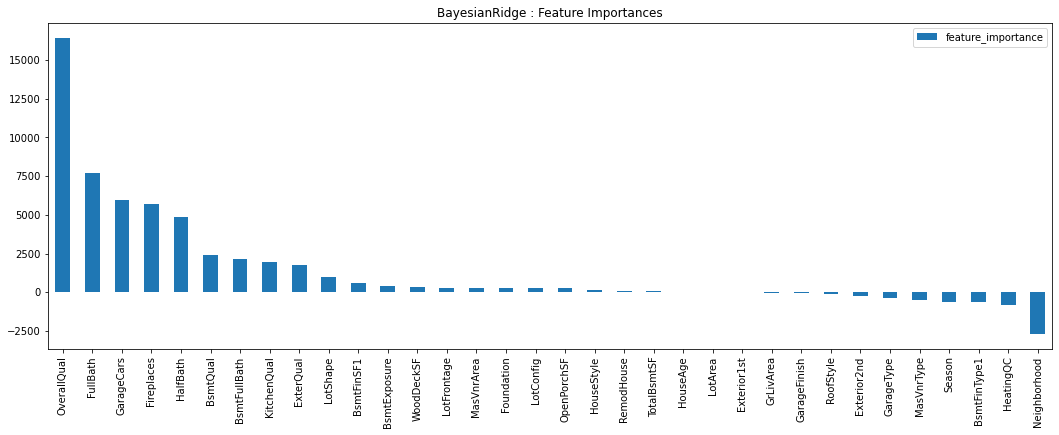

In [479]:
bs_df.sort_values(by = 'feature_importance', ascending = False).plot.bar(figsize = (18, 6))
plt.title('BayesianRidge : Feature Importances')
plt.show()

In [480]:
bs_df.sort_values(by = 'feature_importance', ascending = False)

,feature_importance
OverallQual,16432.963978
FullBath,7695.816299
GarageCars,5989.068593
Fireplaces,5707.947802
HalfBath,4865.131133
BsmtQual,2400.236837
BsmtFullBath,2167.572959
KitchenQual,1928.785854
ExterQual,1769.831999
LotShape,1003.283665


## [GradientBoostingRegressor] Pipeline with best parameters

In [481]:
pipe_gbr = Pipeline(steps = [('imputer_num', MeanMedianImputer(imputation_method = 'median', variables = num_list)), 
                         ('imputer_cat', CategoricalImputer(imputation_method = 'missing', variables = cat_list)), 
                         ('rare_label', RareLabelEncoder(tol = 0.05, n_categories = 3)), 
                         ('discretizer', EqualFrequencyDiscretiser(q = 6, return_object = True, variables = num_list)), 
                         ('encoder', OneHotEncoder()), 
                         ('scaler', StandardScaler()), 
                         ('gbr', GradientBoostingRegressor(n_estimators=250, loss = 'squared_error' ,
                                                          learning_rate=0.1, max_depth = 2, max_features = 'sqrt', 
                                                          min_samples_leaf = 0.01))])

In [482]:
pipe_gbr.fit(X_train, y_train)

Pipeline(steps=[('imputer_num',
                 MeanMedianImputer(variables=['LotFrontage', 'LotArea',
                                              'MasVnrArea', 'BsmtFinSF1',
                                              'TotalBsmtSF', 'GrLivArea',
                                              'WoodDeckSF', 'OpenPorchSF',
                                              'HouseAge', 'RemodHouse'])),
                ('imputer_cat',
                 CategoricalImputer(variables=['LotShape', 'LotConfig',
                                               'Neighborhood', 'HouseStyle',
                                               'RoofStyle', 'Exterior1st',
                                               'Exterior2nd', 'MasVnrType',
                                               'ExterQual'...
                 EqualFrequencyDiscretiser(q=6, return_object=True,
                                           variables=['LotFrontage', 'LotArea',
                                                      'MasVnrArea',
                                                      'BsmtFinSF1',
                                                      'TotalBsmtSF',
                                                      'GrLivArea', 'WoodDeckSF',
                                                      'OpenPorchSF', 'HouseAge',
                                                      'RemodHouse'])),
                ('encoder', OneHotEncoder()), ('scaler', StandardScaler()),
                ('gbr',
                 GradientBoostingRegressor(max_depth=2, max_features='sqrt',
                                           min_samples_leaf=0.01,
                                           n_estimators=250))])

In [483]:
X_train_preds = pipe_gbr.predict(X_train)
X_test_preds = pipe_gbr.predict(X_test)

In [484]:
print('train MAE: {}'.format(mean_absolute_error(y_train, X_train_preds)))
print('train RMSE: {}'.format(sqrt(mean_squared_error(y_train, X_train_preds))))
print('train R2: {}'.format(r2_score(y_train, X_train_preds)))
print()

print('test MAE: {}'.format(mean_absolute_error(y_test, X_test_preds)))
print('test RMSE: {}'.format(sqrt(mean_squared_error(y_test, X_test_preds))))
print('test R2: {}'.format(r2_score(y_test, X_test_preds)))

train MAE: 16107.642993534688
train RMSE: 24017.788605312824
train R2: 0.9054299631481806

test MAE: 19983.586619739854
test RMSE: 32351.410184949666
test R2: 0.845836638614705


### [GradientBoostingRegressor] Feature importances

In [485]:
onehot_columns_gbr = list(pipe_gbr.named_steps['scaler'].feature_names_in_)
importance_gbr = pd.Series(pipe_gbr.named_steps['gbr'].feature_importances_)
importance_gbr.index = onehot_columns_gbr

In [488]:
len(importance_gbr)

138

In [486]:
onehot_columns_gbr

['OverallQual',
 'BsmtFullBath',
 'FullBath',
 'HalfBath',
 'Fireplaces',
 'GarageCars',
 'LotFrontage_2',
 'LotFrontage_0',
 'LotFrontage_1',
 'LotFrontage_3',
 'LotFrontage_4',
 'LotFrontage_5',
 'LotArea_2',
 'LotArea_0',
 'LotArea_1',
 'LotArea_4',
 'LotArea_3',
 'LotArea_5',
 'LotShape_Reg',
 'LotShape_IR1',
 'LotShape_Rare',
 'LotConfig_Inside',
 'LotConfig_Corner',
 'LotConfig_CulDSac',
 'LotConfig_Rare',
 'Neighborhood_CollgCr',
 'Neighborhood_Rare',
 'Neighborhood_Edwards',
 'Neighborhood_Sawyer',
 'Neighborhood_NAmes',
 'Neighborhood_Gilbert',
 'Neighborhood_Somerst',
 'Neighborhood_OldTown',
 'HouseStyle_2Story',
 'HouseStyle_1Story',
 'HouseStyle_1.5Fin',
 'HouseStyle_Rare',
 'RoofStyle_Gable',
 'RoofStyle_Hip',
 'RoofStyle_Rare',
 'Exterior1st_VinylSd',
 'Exterior1st_Wd Sdng',
 'Exterior1st_Rare',
 'Exterior1st_HdBoard',
 'Exterior1st_MetalSd',
 'Exterior1st_Plywood',
 'Exterior2nd_VinylSd',
 'Exterior2nd_Wd Sdng',
 'Exterior2nd_Plywood',
 'Exterior2nd_Rare',
 'Exterior2nd

In [487]:
gbr_feature_names = importance_gbr.rename(index = { 
 'LotFrontage_2': 'LotFrontage',
 'LotFrontage_0': 'LotFrontage',
 'LotFrontage_1': 'LotFrontage',
 'LotFrontage_3': 'LotFrontage',
 'LotFrontage_4': 'LotFrontage',
 'LotFrontage_5': 'LotFrontage',
 'LotArea_2': 'LotArea',
 'LotArea_0': 'LotArea',
 'LotArea_1': 'LotArea',
 'LotArea_4': 'LotArea',
 'LotArea_3': 'LotArea',
 'LotArea_5': 'LotArea',
 'LotShape_Reg': 'LotShape', 
 'LotShape_IR1': 'LotShape', 
 'LotShape_Rare': 'LotShape', 
 'LotConfig_Inside': 'LotConfig', 
 'LotConfig_Corner': 'LotConfig', 
 'LotConfig_CulDSac': 'LotConfig', 
 'LotConfig_Rare': 'LotConfig', 
 'Neighborhood_CollgCr': 'Neighborhood',
 'Neighborhood_Rare': 'Neighborhood',
 'Neighborhood_Edwards': 'Neighborhood',
 'Neighborhood_Sawyer': 'Neighborhood',
 'Neighborhood_NAmes': 'Neighborhood',
 'Neighborhood_Gilbert': 'Neighborhood',
 'Neighborhood_Somerst': 'Neighborhood',
 'Neighborhood_OldTown': 'Neighborhood',
 'HouseStyle_2Story': 'HouseStyle',
 'HouseStyle_1Story': 'HouseStyle',
 'HouseStyle_1.5Fin': 'HouseStyle',
 'HouseStyle_Rare': 'HouseStyle',
 'RoofStyle_Gable': 'RoofStyle',
 'RoofStyle_Hip': 'RoofStyle',
 'RoofStyle_Rare': 'RoofStyle',
 'Exterior1st_VinylSd': 'Exterior1st',
 'Exterior1st_Wd Sdng': 'Exterior1st',
 'Exterior1st_Rare': 'Exterior1st',
 'Exterior1st_HdBoard': 'Exterior1st',
 'Exterior1st_MetalSd': 'Exterior1st',
 'Exterior1st_Plywood': 'Exterior1st',
 'Exterior2nd_VinylSd': 'Exterior2nd',
 'Exterior2nd_Wd Sdng': 'Exterior2nd',
 'Exterior2nd_Plywood': 'Exterior2nd',
 'Exterior2nd_Rare': 'Exterior2nd',
 'Exterior2nd_HdBoard': 'Exterior2nd',
 'Exterior2nd_MetalSd': 'Exterior2nd',
 'MasVnrType_BrkFace': 'MasVnrType',
 'MasVnrType_None': 'MasVnrType',
 'MasVnrType_Stone': 'MasVnrType',
 'MasVnrType_Rare': 'MasVnrType',
 'MasVnrArea_2': 'MasVnrArea',
 'MasVnrArea_0': 'MasVnrArea',
 'MasVnrArea_1': 'MasVnrArea',
 'ExterQual_TA': 'ExterQual',
 'ExterQual_Gd': 'ExterQual',
 'ExterQual_Rare': 'ExterQual',
 'Foundation_PConc': 'Foundation',
 'Foundation_CBlock': 'Foundation',
 'Foundation_BrkTil': 'Foundation',
 'Foundation_Rare': 'Foundation',
 'BsmtQual_Gd': 'BsmtQual',
 'BsmtQual_TA': 'BsmtQual',
 'BsmtQual_Rare': 'BsmtQual',
 'BsmtQual_Ex': 'BsmtQual',
 'BsmtExposure_No': 'BsmtExposure',
 'BsmtExposure_Mn': 'BsmtExposure',
 'BsmtExposure_Gd': 'BsmtExposure',
 'BsmtExposure_Rare': 'BsmtExposure',
 'BsmtExposure_Av': 'BsmtExposure',
 'BsmtFinType1_GLQ': 'BsmtFinType1',
 'BsmtFinType1_BLQ': 'BsmtFinType1',
 'BsmtFinType1_Rec': 'BsmtFinType1',
 'BsmtFinType1_ALQ': 'BsmtFinType1',
 'BsmtFinType1_Unf': 'BsmtFinType1',
 'BsmtFinType1_Rare': 'BsmtFinType1',
 'BsmtFinSF1_2': 'BsmtFinSF1',
 'BsmtFinSF1_3': 'BsmtFinSF1',
 'BsmtFinSF1_0': 'BsmtFinSF1',
 'BsmtFinSF1_1': 'BsmtFinSF1',
 'BsmtFinSF1_4': 'BsmtFinSF1',
 'TotalBsmtSF_2': 'TotalBsmtSF',
 'TotalBsmtSF_3': 'TotalBsmtSF',
 'TotalBsmtSF_1': 'TotalBsmtSF',
 'TotalBsmtSF_0': 'TotalBsmtSF',
 'TotalBsmtSF_4': 'TotalBsmtSF',
 'TotalBsmtSF_5': 'TotalBsmtSF',
 'HeatingQC_Ex': 'HeatingQC',
 'HeatingQC_Gd': 'HeatingQC',
 'HeatingQC_TA': 'HeatingQC',
 'HeatingQC_Rare': 'HeatingQC',
 'GrLivArea_5': 'GrLivArea',
 'GrLivArea_2': 'GrLivArea',
 'GrLivArea_0': 'GrLivArea',
 'GrLivArea_1': 'GrLivArea',
 'GrLivArea_3': 'GrLivArea',
 'GrLivArea_4': 'GrLivArea', 
 'KitchenQual_Gd': 'KitchenQual',
 'KitchenQual_TA': 'KitchenQual',
 'KitchenQual_Rare': 'KitchenQual',
 'KitchenQual_Ex': 'KitchenQual',
 'GarageType_Attchd': 'GarageType',
 'GarageType_Missing': 'GarageType',
 'GarageType_Detchd': 'GarageType',
 'GarageType_Rare': 'GarageType',
 'GarageType_BuiltIn': 'GarageType',
 'GarageFinish_RFn': 'GarageFinish',
 'GarageFinish_Unf': 'GarageFinish',
 'GarageFinish_Missing': 'GarageFinish',
 'GarageFinish_Fin': 'GarageFinish',
 'WoodDeckSF_2': 'WoodDeckSF',
 'WoodDeckSF_0': 'WoodDeckSF',
 'WoodDeckSF_1': 'WoodDeckSF',
 'OpenPorchSF_1': 'OpenPorchSF',
 'OpenPorchSF_0': 'OpenPorchSF',
 'OpenPorchSF_2': 'OpenPorchSF',
 'OpenPorchSF_3': 'OpenPorchSF',
 'HouseAge_1': 'HouseAge',
 'HouseAge_4': 'HouseAge',
 'HouseAge_5': 'HouseAge',
 'HouseAge_2': 'HouseAge',
 'HouseAge_3': 'HouseAge',
 'HouseAge_0': 'HouseAge',
 'RemodHouse_2': 'RemodHouse',
 'RemodHouse_0': 'RemodHouse',
 'RemodHouse_5': 'RemodHouse',
 'RemodHouse_3': 'RemodHouse',
 'RemodHouse_4': 'RemodHouse',
 'RemodHouse_1': 'RemodHouse',
 'Season_winter' : 'Season', 
 'Season_autumn': 'Season', 
 'Season_spring': 'Season', 
 'Season_summer': 'Season'
})

In [489]:
gbr_df = gbr_feature_names.to_frame(name = 'feature_importance')

In [490]:
gbr_df.head(10)

,feature_importance
OverallQual,0.111385
BsmtFullBath,0.001355
FullBath,0.105406
HalfBath,0.008152
Fireplaces,0.066660
GarageCars,0.062494
LotFrontage,0.000075
LotFrontage,0.002129
LotFrontage,0.000000
LotFrontage,0.000090


In [491]:
gbr_df = gbr_df.groupby(level = 0).sum()

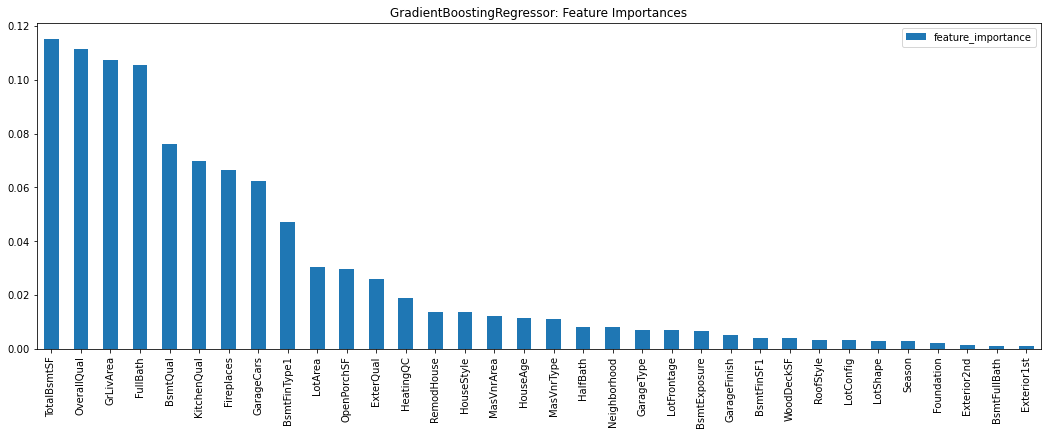

In [493]:
gbr_df.sort_values(by = 'feature_importance', ascending = False).plot.bar(figsize = (18, 6))
plt.title('GradientBoostingRegressor: Feature Importances')
plt.show()

In [494]:
gbr_df.sort_values(by = 'feature_importance', ascending = False)

,feature_importance
TotalBsmtSF,0.115271
OverallQual,0.111385
GrLivArea,0.107432
FullBath,0.105406
BsmtQual,0.076203
KitchenQual,0.069950
Fireplaces,0.066660
GarageCars,0.062494
BsmtFinType1,0.047180
LotArea,0.030631


## Visualization of Actual and Predicted house prices 

### RandomForestRegressor

In [646]:
y_pred_rf = pipe_rfr.predict(X_test)

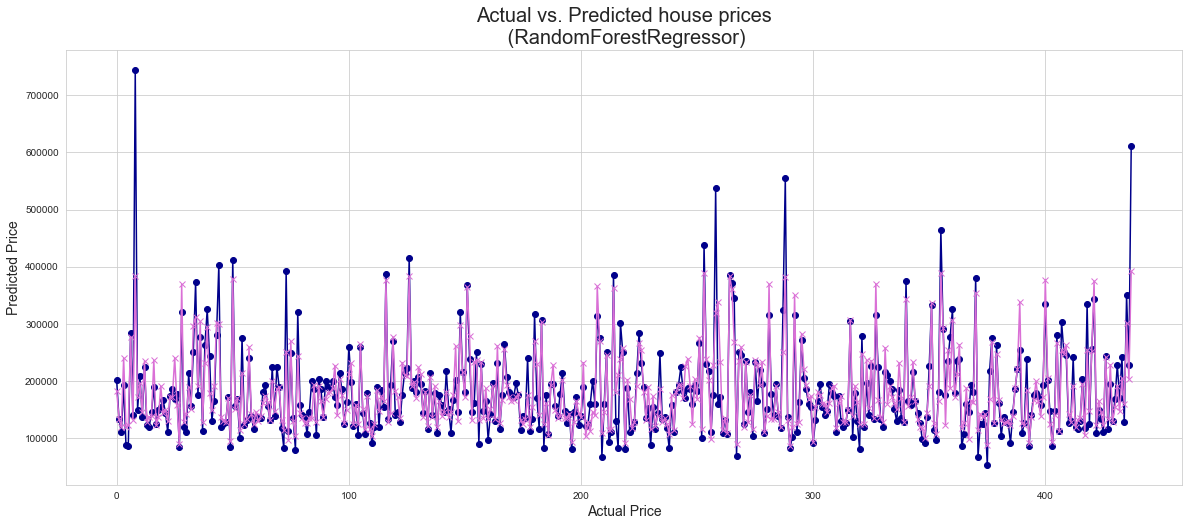

In [647]:
plt.figure(figsize = (20, 8))
plt.plot(y_test, color = 'darkblue', marker = 'o')
plt.plot(y_pred_rf, color = 'orchid', marker = 'x')
plt.title('Actual vs. Predicted house prices\n (RandomForestRegressor)', fontsize = 20)
plt.xlabel('Actual Price', fontsize = 14)
plt.ylabel('Predicted Price', fontsize = 14)
plt.show()

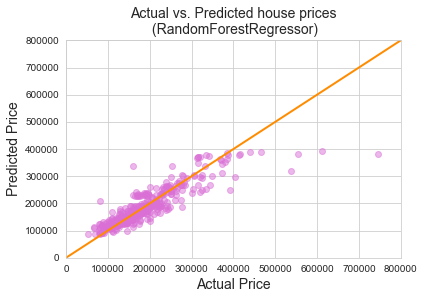

In [648]:
plt.figure()
plt.scatter(y_test, y_pred_rf, c ='orchid', marker="o", facecolors="none", alpha=0.5)
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.title('Actual vs. Predicted house prices\n (RandomForestRegressor)', fontsize=14)
plt.show()

### DecisionTreeRegressor

In [649]:
y_pred_dtr = pipe_dtr.predict(X_test)

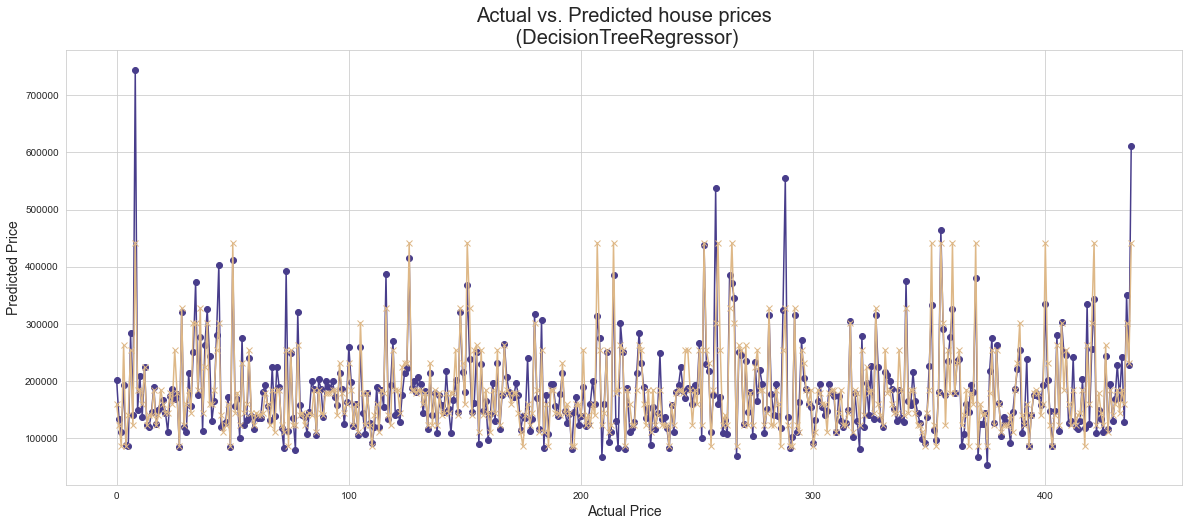

In [650]:
plt.figure(figsize=(20, 8))
plt.plot(y_test, color = 'darkslateblue', marker = 'o')
plt.plot(y_pred_dtr, color = 'burlywood', marker = 'x')
plt.title('Actual vs. Predicted house prices\n (DecisionTreeRegressor)', fontsize=20)
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.show()

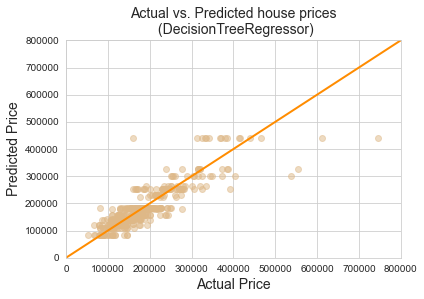

In [651]:
plt.figure()
plt.scatter(y_test, y_pred_dtr, c ='burlywood', marker = 'o', alpha=0.5)
plt.plot([0, 800000], [0, 800000], "darkorange", lw = 2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel('Actual Price', fontsize = 14)
plt.ylabel('Predicted Price', fontsize = 14)
plt.title('Actual vs. Predicted house prices\n (DecisionTreeRegressor)', fontsize = 14)
plt.show()

### XGBoostRegressor

In [653]:
y_pred_xgb = pipe_xgb.predict(X_test)

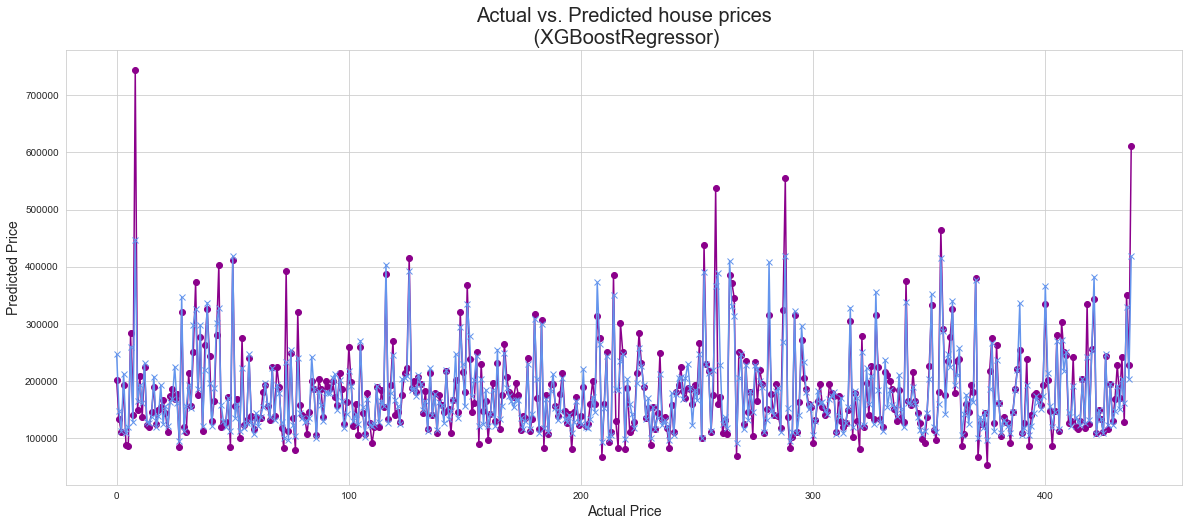

In [654]:
plt.figure(figsize = (20, 8))
plt.plot(y_test, color = 'darkmagenta', marker = 'o')
plt.plot(y_pred_xgb, color = 'cornflowerblue', marker = 'x')
plt.title('Actual vs. Predicted house prices\n (XGBoostRegressor)', fontsize = 20)
plt.xlabel('Actual Price', fontsize = 14)
plt.ylabel('Predicted Price', fontsize = 14)
plt.show()

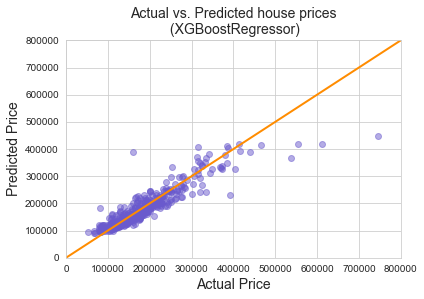

In [655]:
plt.figure()
plt.scatter(y_test, y_pred_xgb, c ='slateblue', marker="o", alpha=0.5)
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.title('Actual vs. Predicted house prices\n (XGBoostRegressor)', fontsize=14)
plt.show()

### Lasso

#### Inverse transform of y_pred after scaling

In [709]:
y_pred_ls = pipe_lasso.predict(X_test)

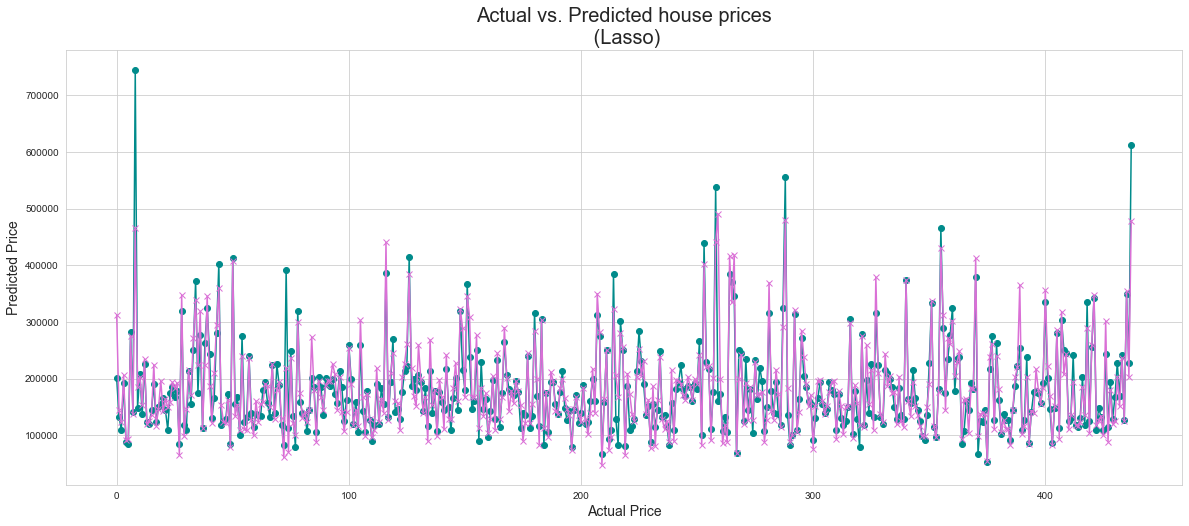

In [710]:
plt.figure(figsize = (20, 8))
plt.plot(y_test, color = 'darkcyan', marker = 'o')
plt.plot(y_pred_ls, color = 'orchid', marker = 'x')
plt.title('Actual vs. Predicted house prices\n (Lasso)', fontsize = 20)
plt.xlabel('Actual Price', fontsize = 14)
plt.ylabel('Predicted Price', fontsize = 14)
plt.show()

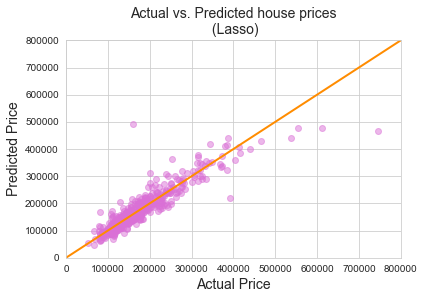

In [702]:
plt.figure()
plt.scatter(y_test, y_pred_ls, c ='orchid', marker="o", alpha=0.5)
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.title('Actual vs. Predicted house prices\n (Lasso)', fontsize=14)
plt.show()

### KNeighborsRegressor

In [656]:
y_pred_knn = pipe_knn.predict(X_test)

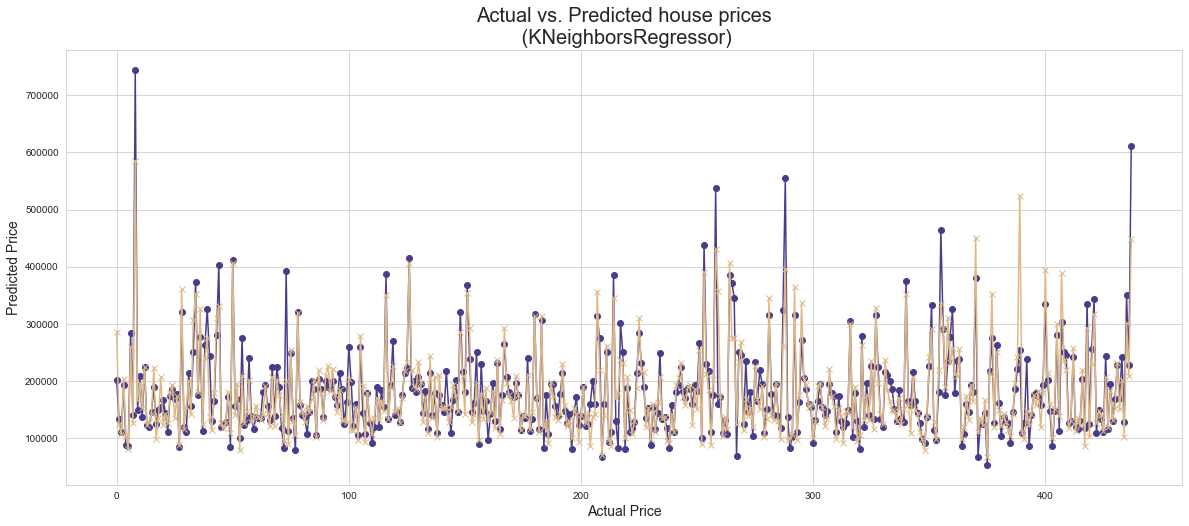

In [657]:
plt.figure(figsize = (20, 8))
plt.plot(y_test, color = 'darkslateblue', marker = 'o')
plt.plot(y_pred_knn, color = 'burlywood', marker = 'x')
plt.title('Actual vs. Predicted house prices\n (KNeighborsRegressor)', fontsize = 20)
plt.xlabel('Actual Price', fontsize = 14)
plt.ylabel('Predicted Price', fontsize = 14)
plt.show()

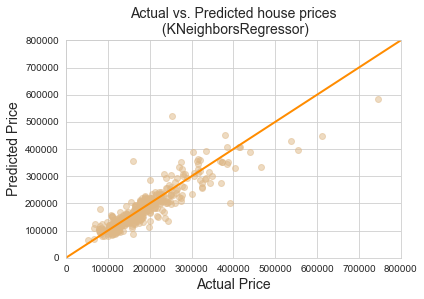

In [658]:
plt.figure()
plt.scatter(y_test, y_pred_knn, c ='burlywood', marker="o", alpha=0.5)
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.title('Actual vs. Predicted house prices\n (KNeighborsRegressor)', fontsize=14)
plt.show()

### GradientBoostingRegressor

In [ ]:
y_pred_gbr = scaler.inverse_transform(pipe_gbr.predict(X_test).reshape(-1, 1))

In [659]:
y_pred_gbr = pipe_gbr.predict(X_test)

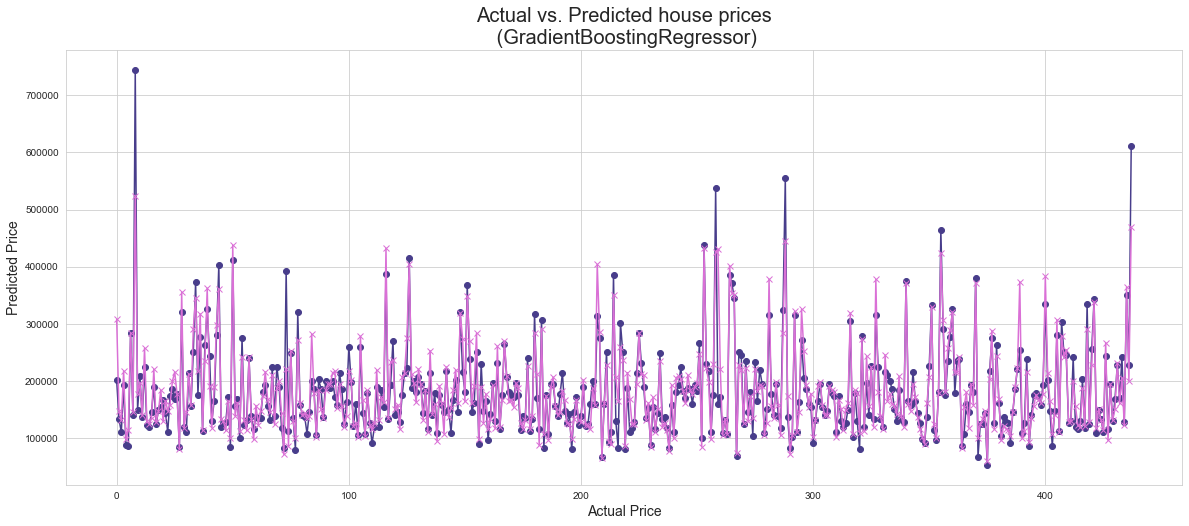

In [660]:
plt.figure(figsize = (20, 8))
plt.plot(y_test, color = 'darkslateblue', marker = 'o')
plt.plot(y_pred_gbr, color = 'orchid', marker = 'x')
plt.title('Actual vs. Predicted house prices\n (GradientBoostingRegressor)', fontsize = 20)
plt.xlabel('Actual Price', fontsize = 14)
plt.ylabel('Predicted Price', fontsize = 14)
plt.show()

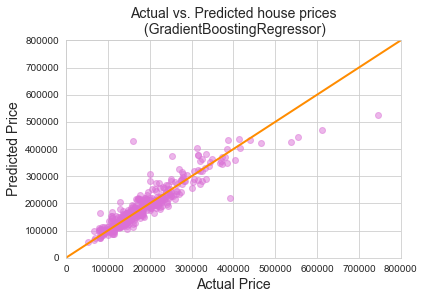

In [661]:
plt.figure()
plt.scatter(y_test, y_pred_gbr, c ='orchid', marker="o", alpha=0.5)
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.title('Actual vs. Predicted house prices\n (GradientBoostingRegressor)', fontsize=14)
plt.show()

### BayesianRidge

In [663]:
y_pred_bayesian = pipe_bayesian.predict(X_test)

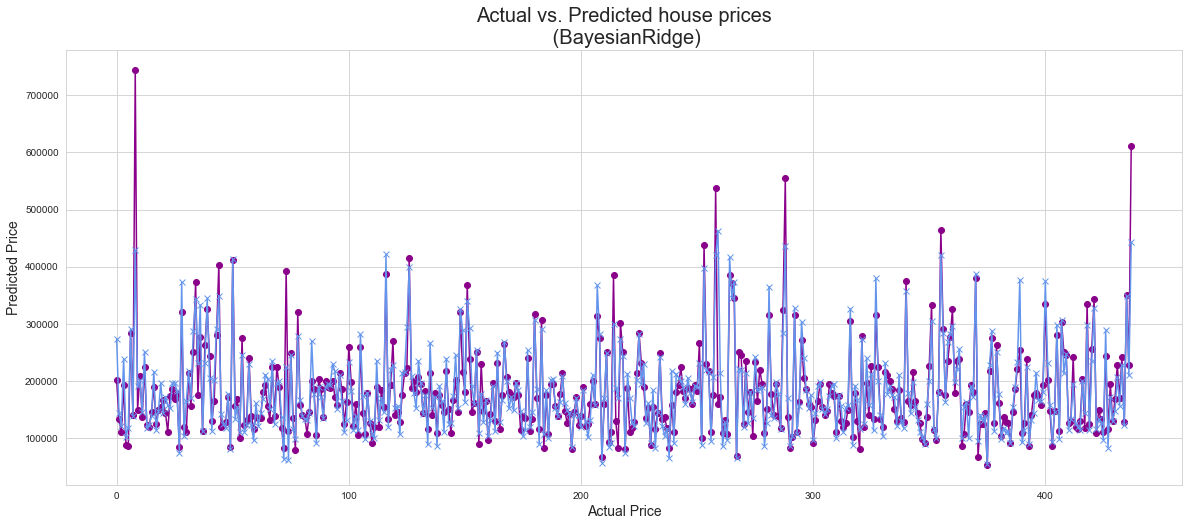

In [664]:
plt.figure(figsize = (20, 8))
plt.plot(y_test, color = 'darkmagenta', marker = 'o')
plt.plot(y_pred_bayesian, color = 'cornflowerblue', marker = 'x')
plt.title('Actual vs. Predicted house prices\n (BayesianRidge)', fontsize = 20)
plt.xlabel('Actual Price', fontsize = 14)
plt.ylabel('Predicted Price', fontsize = 14)
plt.show()

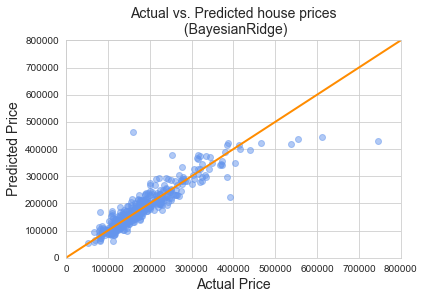

In [665]:
plt.figure()
plt.scatter(y_test, y_pred_bayesian, c ='cornflowerblue', marker="o", alpha=0.5)
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.title('Actual vs. Predicted house prices\n (BayesianRidge)', fontsize=14)
plt.show()

## SVR

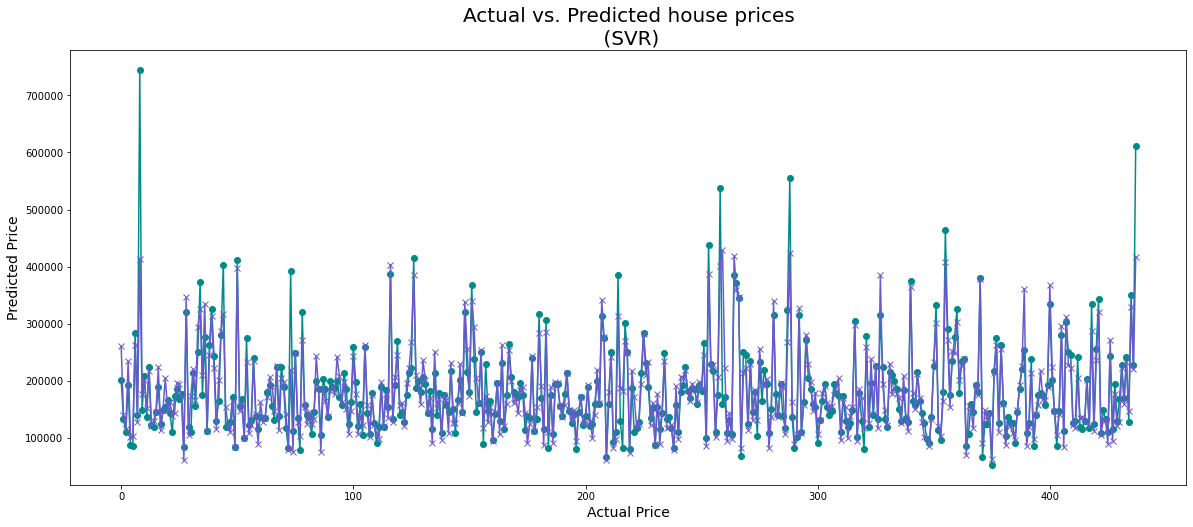

In [496]:
plt.figure(figsize = (20, 8))
plt.plot(y_test, color = 'darkcyan', marker = 'o')
plt.plot(X_test_svr1, color = 'slateblue', marker = 'x')
plt.title('Actual vs. Predicted house prices\n (SVR)', fontsize = 20)
plt.xlabel('Actual Price', fontsize = 14)
plt.ylabel('Predicted Price', fontsize = 14)
plt.show()

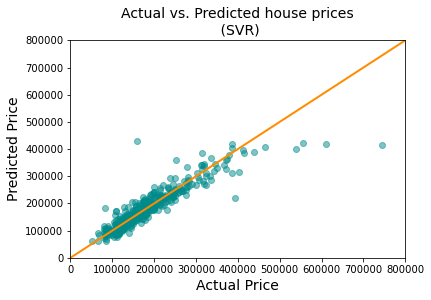

In [119]:
plt.figure()
plt.scatter(y_test, X_test_svr1, c ='darkcyan', marker="o", alpha=0.5)
plt.plot([0, 800000], [0, 800000], "darkorange", lw=2)
plt.xlim(0, 800000)
plt.ylim(0, 800000)
plt.xlabel('Actual Price', fontsize=14)
plt.ylabel('Predicted Price', fontsize=14)
plt.title('Actual vs. Predicted house prices\n (SVR)', fontsize=14)
plt.show()